# EM casing response

In [1]:
import numpy as np
import scipy.sparse as sp
from scipy.constants import mu_0
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, LinearSegmentedColormap, Normalize, SymLogNorm
from matplotlib import cm as colormap
import time
from string import ascii_lowercase
from multiprocessing import Pool
import pickle

# SimPEG, discretize/
import discretize
from discretize import utils
from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG.electromagnetics import resistivity as dc
from SimPEG import utils, maps, Report
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casing_sim

In [2]:
path_to_data = "/t40array/lheagy/casing-permeability"

In [3]:
from matplotlib import rcParams
rcParams["font.size"] = 16

In [4]:
save_figures = False
fig_dir_high = "figures"
fig_dir_low = "low-rez-figures"

dpi_high=400
dpi_low=150

## Simulation parameters

In [5]:
run_simulations = True
directory = f"{path_to_data}/fields_permeability_fdem_length_2"

In [6]:
import os
if not os.path.exists(directory):
    os.makedirs(directory)

In [7]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-1
sigma_casing = 5e6
mur_casing = np.r_[1, 50, 100, 150, 200]

# casing geometry
casing_b = 5e-2  
casing_t = 10e-3
casing_a = casing_b - casing_t
casing_l = np.r_[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]

In [8]:
# skin depth
503/np.sqrt(sigma_back)

1590.6256630646947

In [9]:
return_electrode_r = 500
src_a = np.r_[casing_a+casing_t/2, 0, 0]
src_b = np.r_[return_electrode_r, 0., 0.]

In [10]:
csz = 5
nabove = 3
npadz = 18
pf = 1.4

hx = casing_sim.mesh.pad_for_casing_and_data(
    casing_b,
    csx1=casing_t/4., 
    npadx=13,
    csx2=25,
    domain_x=return_electrode_r,
    pfx2=pf
)

# Theta discretization
ny = 12
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

# vertical discretization
ncz = casing_l.max()/csz
hz = discretize.utils.unpack_widths([(csz, npadz, -pf), (csz, ncz+nabove), (csz, npadz, pf)])

# create the mesh
mesh = discretize.CylindricalMesh([hx, hy, hz], x0=np.r_[0,0,-hz[:-npadz-nabove].sum()])
print(mesh.n_cells)

258120


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:247: FutureWarning: meshTensor has been deprecated, please use unpack_widths. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


In [11]:
frequencies = np.r_[0.1, 1, 5, 10] #np.logspace(-1, 2, 19)  
frequencies = np.array([float(f"{f:1.1e}") for f in frequencies])
print(frequencies)
print(503/np.sqrt(sigma_back*frequencies))
print(503/np.sqrt(sigma_casing*frequencies))

[ 0.1  1.   5.  10. ]
[5030.         1590.62566306  711.34942187  503.        ]
[0.71134942 0.22494844 0.1006     0.07113494]


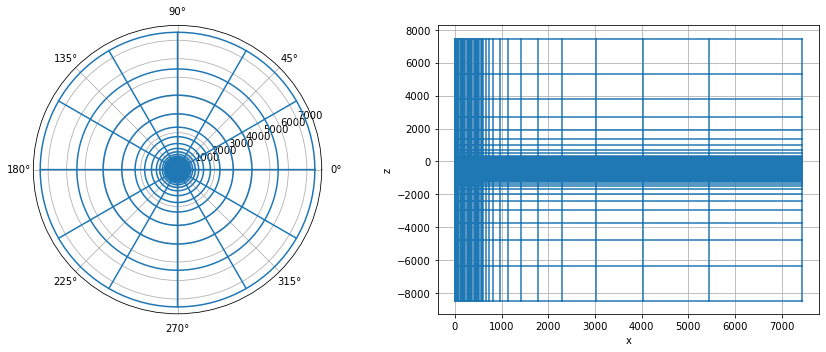

In [12]:
ax = mesh.plot_grid()

In [13]:
def get_inds_casing(length): 
    inds_casing_x = (
        (mesh.cell_centers[:, 0] > casing_a) & 
        (mesh.cell_centers[:, 0] < casing_b)
    )
    inds_casing_z = (
        (mesh.cell_centers[:, 2] < 0) &
        (mesh.cell_centers[:, 2] > -length)
    )
    return inds_casing_x & inds_casing_z

In [27]:
models = {}

halfspace_conductivity = sigma_back * np.ones(mesh.n_cells)
halfspace_conductivity[mesh.cell_centers[:, 2] > 0] = sigma_air

models["halfspace"] = {
    "sigma": halfspace_conductivity, 
    "mur": np.ones(mesh.n_cells)
} 

for l in casing_l: 

    inds_casing = get_inds_casing(l)
    
    casing_conductivity = halfspace_conductivity.copy()
    casing_conductivity[inds_casing] = sigma_casing

    for mur in mur_casing:
        key = f"casing_{mur:1.0f}_{l:1.0f}"
        casing_mur = np.ones(mesh.n_cells)
        casing_mur[inds_casing] = mur
        casing_permeability = casing_mur
        models[key] = {
            "sigma": casing_conductivity, 
            "mur": casing_permeability
        }
    
# for l in casing_l: 
#     for mur in mur_casing: 
#         if mur > 1:
#             key_eq_conductance = f"conductive_casing_{mur*sigma_casing:1.2e}_{l:1.0f}"
            
#             inds_casing = get_inds_casing(l)
#             casing_conductivity = halfspace_conductivity.copy()
#             casing_conductivity[inds_casing] = sigma_casing * mur
            
#             models[key_eq_conductance] = {
#                 "sigma": casing_conductivity, 
#                 "mur": np.ones_like(casing_conductivity) 
#             }
     
            


In [28]:
def plot_casing(ax, model): 
    xlim = 0.22*np.r_[-1, 1]
    zlim = np.r_[-700, 50]
    pcolor_opts={"norm":LogNorm(), "cmap":"Spectral_r"}
    out = casing_sim.view.plot_slice(
        mesh, model, pcolor_opts=pcolor_opts, ax=ax,
    )
    out[-1].set_label("conductivity (S/m)")
    ax.set_xlim(xlim)
    ax.set_ylim(zlim)

    ax.text(xlim[0]*0.9, -675, f"background: {1/sigma_back:1.0f} $\Omega$m", fontsize=16)
    ax.text(xlim[0]*0.9, 10, f"air: {1/sigma_air:1.0e} $\Omega$m", color="w", fontsize=16)
    ax.text(casing_b+0.01, -300, f"casing:\n{sigma_casing:1.0e} S/m\n$\mu>\mu_0$", fontsize=16)
    for sign in np.r_[-1, 1]: 
        ax.arrow(
            0, -casing_l.max()+60, casing_a*sign, 0, length_includes_head=True, shape="full", width=1e-2,
            head_length=1e-2, head_width=10, color="k"
        )

        ax.arrow(
            0, -casing_l.max()-8, casing_b*sign, 0, length_includes_head=True, shape="full", width=1e-2,
            head_length=1e-2, head_width=10, color="k"
        )
    ax.text(0, -casing_l.max()+25, f"{casing_a*1e2*2:1.0f} cm", ha="center")
    ax.text(0, -casing_l.max()-45, f"{casing_b*1e2*2:1.0f} cm", ha="center")
    ax.set_xlabel("x (m)")
    ax.set_ylabel("z (m)")
    return ax

In [29]:
def plot_geometry(ax, perpendicular=False):
    survey_lim = (return_electrode_r + 70) * np.r_[-1, 1]
    norm = LogNorm(vmin=sigma_air, vmax=sigma_casing)
    cmap = colormap.get_cmap("Spectral_r")
    ax.set_facecolor(cmap(norm(sigma_back)))

    ax.plot(np.r_[0, return_electrode_r], np.r_[0, 0], color="k", marker="v")
    if perpendicular is False: 
        ax.plot(np.r_[-return_electrode_r, 0], np.r_[0, 0], color="k", ls=":")
    else: 
        ax.plot(np.r_[0, 0], np.r_[0, return_electrode_r], color="k", ls=":")
    ax.plot(0, 0, "o", color=cmap(norm(sigma_casing)), ms=8)

    ax.text(return_electrode_r/2, 10, "transmitter", ha="center")
    ax.text(0, -75, "casing", ha="center")
    
    if perpendicular is False: 
        ax.text(-return_electrode_r/2, 10, "receivers", ha="center")
    else: 
        ax.text(0, return_electrode_r/2, "receivers", ha="right")

    ax.set_xlim(survey_lim)
    ax.set_ylim(survey_lim)
    ax.set_aspect(1)
    ax.set_xlabel("x (m)")
    ax.set_ylabel("y (m)")
    return ax


Text(0.5, 1.0, '(b)')

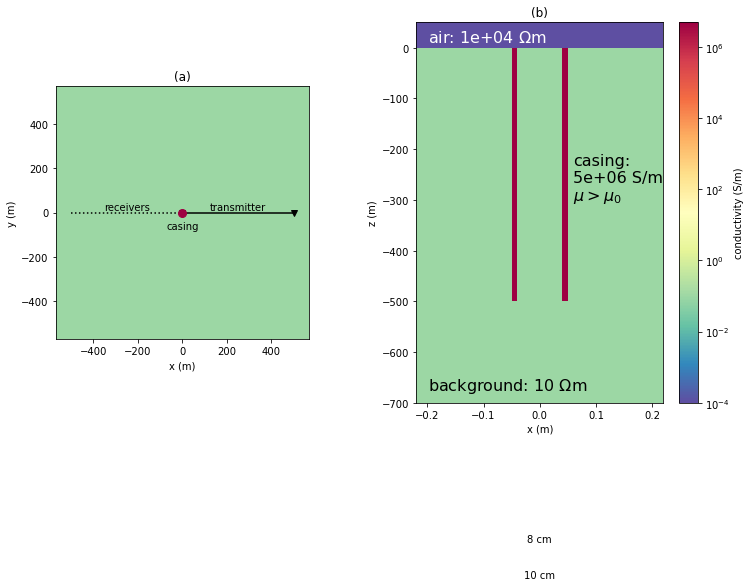

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7), gridspec_kw={'width_ratios': [1, 1.22], "wspace":0.38})

plot_geometry(ax[0], False)
plot_casing(ax[1], models["casing_200_500"]["sigma"])

ax[0].set_title("(a)")
ax[1].set_title("(b)")

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/setup", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig(f"{fig_dir_low}/setup", dpi=dpi_low, bbox_inches="tight")

## set up the simulations

In [31]:
# top casing source 
src_theta = mesh.hy[0]/2.
src_a = np.r_[casing_b - mesh.hx.min()/2, src_theta, -csz/2]
src_b = np.r_[return_electrode_r, src_theta, -csz/2]
src_locations = np.vstack(
    [
        src_a, src_a+np.r_[0, 0, csz*1.5], src_b+np.r_[0, 0, csz*1.5], src_b
    ]
)
src_locations

array([[ 4.88442571e-02,  2.61799388e-01, -2.50000000e+00],
       [ 4.88442571e-02,  2.61799388e-01,  5.00000000e+00],
       [ 5.00000000e+02,  2.61799388e-01,  5.00000000e+00],
       [ 5.00000000e+02,  2.61799388e-01, -2.50000000e+00]])

In [32]:
def generate_simulation(mur, freq=None): 
    if freq is not None: 
        freqs = [freq]
    else:
        freqs = frequencies
    src_list = [
        fdem.sources.LineCurrent([], location=src_locations, frequency=f)
        for f in freqs
    ]
    survey = fdem.Survey(src_list)
    sim = fdem.simulation.Simulation3DCurrentDensity(
        mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
        survey=survey, solver=Pardiso, mu=mur*mu_0,
        verbose=True
    )
    return sim

In [33]:
def load_fields(name, conductivity, mur):
    sim = generate_simulation(mur)
    sim.model = conductivity
    f = sim.fieldsPair(sim)
    for i, freq in enumerate(frequencies): 
        filename = f"{directory}/fields_{name}_{freq}.npy"
        if not os.path.exists(filename): 
            run_simulation(name)
        solution = np.load(filename)
        src = sim.survey.source_list[i]
        f[src, sim._solutionType] = solution
    return f

In [34]:
if run_simulations: 
    mesh.save(f"{directory}/mesh.json")
    np.save(f"{directory}/frequencies", frequencies)
    with open(f"{directory}/models.pkl", "wb") as fp:
        pickle.dump(models, fp)

In [35]:
def run_simulation(key):
    for freq in frequencies: 
        t = time.time()
        filename = f"{directory}/fields_{key}_{freq}.npy"
        # if os.path.exists(filename):
        #     pass
        # else: 
        print(f"starting {key}, {freq} Hz")
        sim = generate_simulation(models[key]["mur"], freq)
        f = sim.fields(models[key]["sigma"])
        np.save(f"{directory}/fields_{key}_{freq}", f[:, f"{sim._solutionType}"])
        print(f" ... done {key} {freq}. {time.time()-t:1.2e} s\n")
    return 

In [36]:
def generate_dc_simulation(): 
    src_list = [
        dc.sources.Dipole([], location_a=src_locations[0,:], location_b=src_locations[-1,:])
    ]
        
    survey = dc.Survey(src_list)
    sim = dc.simulation.Simulation3DCellCentered(
        mesh=mesh, sigmaMap=maps.IdentityMap(mesh),
        survey=survey, solver=Pardiso, bc_type="Dirichlet",
    #     verbose=True
    )
    return sim

In [37]:
def load_dc_fields(name, conductivity):
    solution = np.load(f"{directory}/fields_dc_{name}.npy")
    sim = generate_dc_simulation()
    sim.model = conductivity
    f = sim.fieldsPair(sim)
    f[:, "phiSolution"] = solution
    return f

In [38]:
def run_dc_simulation(key):
    t = time.time()
    filename = f"{directory}/fields_dc_{key}.npy"
    # if os.path.exists(filename):
    #     pass
    # else:
    print(f"starting {key}\n")
    sim = generate_dc_simulation()
    f = sim.fields(models[key]["sigma"])
    np.save(f"{directory}/fields_dc_{key}", f[:, f"phi"])
    print(f" ... done {key}. {time.time()-t:1.2e} s\n")
    return

In [39]:
models.keys()

dict_keys(['halfspace', 'casing_1_100', 'casing_50_100', 'casing_100_100', 'casing_150_100', 'casing_200_100', 'casing_1_200', 'casing_50_200', 'casing_100_200', 'casing_150_200', 'casing_200_200', 'casing_1_300', 'casing_50_300', 'casing_100_300', 'casing_150_300', 'casing_200_300', 'casing_1_400', 'casing_50_400', 'casing_100_400', 'casing_150_400', 'casing_200_400', 'casing_1_500', 'casing_50_500', 'casing_100_500', 'casing_150_500', 'casing_200_500', 'casing_1_600', 'casing_50_600', 'casing_100_600', 'casing_150_600', 'casing_200_600', 'casing_1_700', 'casing_50_700', 'casing_100_700', 'casing_150_700', 'casing_200_700', 'casing_1_800', 'casing_50_800', 'casing_100_800', 'casing_150_800', 'casing_200_800', 'casing_1_900', 'casing_50_900', 'casing_100_900', 'casing_150_900', 'casing_200_900', 'casing_1_1000', 'casing_50_1000', 'casing_100_1000', 'casing_150_1000', 'casing_200_1000'])

In [40]:
# run_simulation("halfspace")

In [41]:
# if run_simulations: 
#     for key in models.keys():
#         run_simulation(key)

In [43]:
if run_simulations:   
    with Pool(3) as p:
        p.map(run_simulation, list(models.keys()))  

starting casing_200_200, 0.1 Hzstarting halfspace, 0.1 Hzstarting casing_200_100, 0.1 Hz




/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.area has been deprecated, please use CylindricalMesh.face_areas. It will be removed in version 1.0.0 of discretize.
  warnings.warn(m

 ... done casing_200_100 0.1. 7.36e+01 s

starting casing_200_100, 1.0 Hz
 ... done halfspace 0.1. 1.02e+02 s

starting halfspace, 1.0 Hz
 ... done casing_200_200 0.1. 1.04e+02 s

starting casing_200_200, 1.0 Hz
 ... done casing_200_100 1.0. 7.53e+01 s

starting casing_200_100, 5.0 Hz
 ... done halfspace 1.0. 9.90e+01 s

starting halfspace, 5.0 Hz
 ... done casing_200_200 1.0. 9.78e+01 s

starting casing_200_200, 5.0 Hz
 ... done casing_200_100 5.0. 7.33e+01 s

starting casing_200_100, 10.0 Hz
 ... done halfspace 5.0. 8.74e+01 s

starting halfspace, 10.0 Hz
 ... done casing_200_200 5.0. 9.19e+01 s

starting casing_200_200, 10.0 Hz
 ... done casing_200_100 10.0. 7.97e+01 s

starting casing_1_200, 0.1 Hz
 ... done halfspace 10.0. 8.49e+01 s

starting casing_1_100, 0.1 Hz
 ... done casing_200_200 10.0. 8.68e+01 s

starting casing_1_300, 0.1 Hz
 ... done casing_1_200 0.1. 8.55e+01 s

starting casing_1_200, 1.0 Hz
 ... done casing_1_200 1.0. 7.65e+01 s

starting casing_1_200, 5.0 Hz
 ... do

In [44]:
dc_keys = []

for k in models.keys():
    if "halfspace" in k:
        dc_keys.append(k)
    elif "casing" in k:
        if k.split("_")[1] == "1": 
            dc_keys.append(k)
        elif "conductive" in k:
            dc_keys.append(k)

dc_keys

['halfspace',
 'casing_1_100',
 'casing_1_200',
 'casing_1_300',
 'casing_1_400',
 'casing_1_500',
 'casing_1_600',
 'casing_1_700',
 'casing_1_800',
 'casing_1_900',
 'casing_1_1000']

In [45]:
for k in dc_keys: 
    run_dc_simulation(k)

starting halfspace



/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.faceDiv has been deprecated, please use CylindricalMesh.face_divergence. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


 ... done halfspace. 4.25e+00 s

starting casing_1_100

 ... done casing_1_100. 2.64e+00 s

starting casing_1_200

 ... done casing_1_200. 2.76e+00 s

starting casing_1_300

 ... done casing_1_300. 2.61e+00 s

starting casing_1_400

 ... done casing_1_400. 2.62e+00 s

starting casing_1_500

 ... done casing_1_500. 2.86e+00 s

starting casing_1_600

 ... done casing_1_600. 2.65e+00 s

starting casing_1_700

 ... done casing_1_700. 2.75e+00 s

starting casing_1_800

 ... done casing_1_800. 2.48e+00 s

starting casing_1_900

 ... done casing_1_900. 2.61e+00 s

starting casing_1_1000

 ... done casing_1_1000. 2.75e+00 s



In [46]:
fields = {}
for key in models.keys():
    fields[key] = load_fields(key, models[key]["sigma"], models[key]["mur"])

/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.edgeCurl has been deprecated, please use CylindricalMesh.edge_curl. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [47]:
fields_dc = {}
for k in dc_keys:
    fields_dc[k] = load_dc_fields(k, models[k]["sigma"])

In [48]:
rcParams["font.size"] = 13

In [51]:
freq_inds_plot = np.r_[0, 1, 2, 3]
frequencies[freq_inds_plot]

array([ 0.1,  1. ,  5. , 10. ])

/home/lheagy/git/simpeg/discretize/discretize/mixins/mpl_mod.py:308: FutureWarning: streamOpts has been deprecated, please use stream_opts
  warnings.warn(
/home/lheagy/git/simpeg/discretize/discretize/mixins/mpl_mod.py:324: FutureWarning: vType has been deprecated, please use v_type
  warnings.warn(


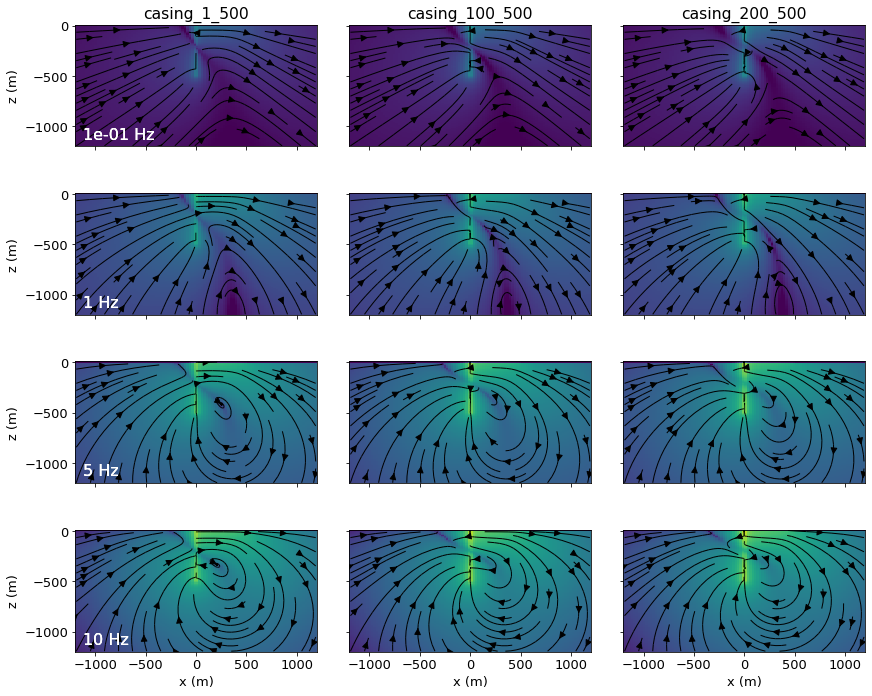

In [52]:
plot_l = 500
plot_mur = np.r_[1, 100, 200]
plot_keys = [f"casing_{mur}_{plot_l}" for mur in plot_mur] # ["halfspace", "casing_1", "casing_200"]

fig, ax = plt.subplots(
    len(freq_inds_plot), len(plot_keys), 
    figsize=(4*len(plot_keys), (len(freq_inds_plot))*2.4),
    constrained_layout=True,
    sharex=True, sharey=True, 
    gridspec_kw={"hspace":0.07,"wspace":0.1}
)

reim = "imag" 
xlim=1200 * np.r_[-1, 1]
zlim=np.r_[-1200, 10]
clim = np.r_[1e-9, 9e-5]

stream_opts={"color":"k", "density":0.6, "arrowsize":1.4, "linewidth":1}


for j, key in enumerate(plot_keys):
    f = fields[key]
    
    for i, freq in enumerate(frequencies[freq_inds_plot]): 
        out = casing_sim.view.plot_cross_section(
            f,
            view="j",
            xlim=xlim,
            zlim=zlim,
            theta_ind=0,
            ax=ax[i, j], 
            clim=clim,
            show_cb=False,
            stream_opts=stream_opts,
            real_or_imag=reim,
            src_ind=freq_inds_plot[i], 
        )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
        ax[i, j].set_title("")
        if freq < 1: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0e} Hz", color="w", fontsize=16)
        else: 
            ax[i, 0].text(xlim.min()+75, zlim.min()+75, f"{freq:1.0f} Hz", color="w", fontsize=16)
        if i < len(frequencies)-1:
            ax[i, j].set_xlabel("")
        else:
            ax[i, j].set_xlabel("x (m)")
        if j > 0: 
            ax[i, j].set_ylabel("")
        else:
            ax[i, j].set_ylabel("z (m)")
        ax[i, j].set_aspect(1)
    ax[0, j].set_title(key)

# ax[0, 0].set_title("(a)\nhalfspace")
# ax[0, 1].set_title("(b)\nconductive casing")
# ax[0, 2].set_title("(c)\nconductive, permeable casing")
# cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.6)
# cb.set_label("current density (A/m$^2$)")

# if save_figures: 
#     fig.savefig(f"{fig_dir_high}/fdem-cross-section-currents", dpi=dpi_high, bbox_inches="tight")
#     fig.savefig(f"{fig_dir_low}/fdem-cross-section-currents", dpi=dpi_low, bbox_inches="tight")

In [ ]:
# fig, ax = plt.subplots(
#     2, len(frequencies),
#     figsize=(len(frequencies)*2.2, 10),
#     constrained_layout=True,
#     sharex=True, sharey=True, 
#     gridspec_kw={"hspace":0.09,"wspace":0.05}
# )

# xlim= 0.075 * np.r_[-1, 1]
# zlim=np.r_[-1100, 5]
# clim = np.r_[2e-4, 2e2]

# stream_opts={"color":"k", "density":2, "arrowsize":1.4, "linewidth":1.5, "minlength":0.4}


# for i, key in enumerate(["casing_1", "casing_100"]):
#     f = fields[key]
    
#     for j, freq in enumerate(frequencies): 
#         out = casing_sim.view.plot_cross_section(
#             f,
#             view="j",
#             xlim=xlim,
#             zlim=zlim,
#             theta_ind=0,
#             ax=ax[i, j], 
#             clim=clim,
#             show_cb=False,
#             stream_opts=stream_opts,
#             real_or_imag="real",
#             src_ind=j, 
#         )
#         ax[i, j].plot(np.r_[0, 0], np.r_[0, return_electrode_r], "w--")
#         ax[i, j].set_title("")
        
#         if freq < 1: 
#             ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0e} Hz", color="w", fontsize=16, ha="right")
#         else:
#             ax[0, j].text(0.07, zlim.min()+50, f"{freq:1.0f} Hz", color="w", fontsize=16, ha="right")
        
#         if i == 0:
#             ax[i, j].set_xlabel("")
#         else:
#             ax[i, j].set_xlabel("x (m)")
#         if j > 0: 
#             ax[i, j].set_ylabel("")
#         else:
#             ax[i, j].set_ylabel("z (m)")
#         ax[i, j].set_xlim([0.02, 0.075])
#         # ax[i, j].set_aspect(1)
#     # ax[0, j].set_title(key)

# cb = plt.colorbar(out[0], ax=ax[-1, :], orientation="horizontal", shrink=0.4)
# cb.set_label("current density (A/m$^2$)")

# # ax[0, 3].set_title("(a) conductive casing", fontsize=18, pad=8)
# # ax[1, 3].set_title("(b) conductive, permeable casing", fontsize=18, pad=8)

# # if save_figures: 
# #     fig.savefig(f"{fig_dir_high}/tdem-casing-currents", dpi=dpi_high, bbox_inches="tight")
# #     fig.savefig(f"{fig_dir_low}/tdem-casing-currents", dpi=dpi_low, bbox_inches="tight")

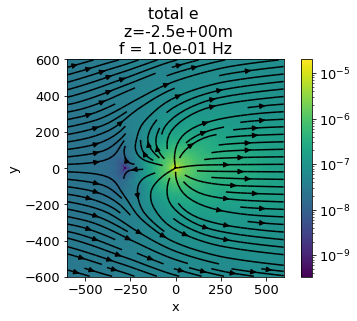

In [1399]:
fig, ax = plt.subplots(1, 1)
key = "casing_200_500"
primary_key = "casing_1_500"
f = fields[key]
xlim=600*np.r_[-1, 1]
src_ind=0
zind = 117
out = casing_sim.view.plot_depth_slice(
    f,
    view="e",
    primary_fields=fields[primary_key],
    prim_sec="total",
    src_ind=src_ind,
    xlim=xlim,
    ylim=xlim,
    z_ind=zind, 
    theta_shift=0.5*mesh.hy[0],
    ax=ax, 
    # clim=clim,
    # show_cb=False,
    k=30,
    component="vec",
    real_or_imag="imag",
    # stream_opts=stream_opts
)

ax.set_aspect(1)

In [ ]:
def plot_cross_section_field(
    key, field, src_ind=0, theta_ind=3, ax=None, 
    xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 10],
    real_or_imag="real", 
    prime_sec="total", primary_fields=None, 
    primary_src_ind=None,
    log_scale=False, eps=1e-15, vmin=None, clim=None,
    component="both", show_colorbar=True,
    stream_opts=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

    mesh2d = casing_sim.utils.mesh2d_from_3d(mesh)

    if field in ["b", "h", "dbdt", "dhdt"]: 
        ave = mesh.average_edge_to_cell_vector
    elif field in ["e", "j"]:
        ave = mesh.average_face_to_cell_vector
    src = fields[key].survey.source_list[src_ind]    
    field_plot = ave * getattr(fields[key][src, field], real_or_imag)
    
    if prime_sec in ["secondary", "percent", "primary"]:
        if primary_src_ind is None: 
            primary_src_ind = src_ind
        primary_src = primary_fields.survey.source_list[primary_src_ind] 
        primary = ave * getattr(primary_fields[primary_src, field], real_or_imag)
        if prime_sec == "primary": 
            field_plot = primary
        else: 
            field_plot = field_plot - primary
            if prime_sec == "percent":
                field_plot = dfield_plot / np.abs(primary + eps) * 100

    
    components = ["x", "y", "z"]
    field_components = {}

    theta_ind_mirror = casing_sim.view.get_theta_ind_mirror(mesh, theta_ind)

    for i, comp in enumerate(components):
        fieldi = field_plot[i*mesh.n_cells:(i+1)*mesh.n_cells].reshape(
            mesh.vnC, order="F"
        )

        field_components[comp] = {
            "data":discretize.utils.mkvc(fieldi[:, theta_ind]),
            "mirror":(
                discretize.utils.mkvc(fieldi[:, theta_ind_mirror]) * 
                [-1 if comp=="y" else 1][0]
            ),
        }

    if component == "both" or component == "xz": 
        if component == "both":
            ax_xz = ax[0]
        else:
            ax_xz = ax
        # plot x,z vector
        fieldxz = np.hstack([field_components[c]["data"] for c in ["x", "z"]])
        fieldxz_mirror = np.hstack([field_components[c]["mirror"] for c in ["x", "z"]])

        sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]

        vmax = clim.max() if clim is not None else None
        if log_scale is True: 
            norm = LogNorm(vmin=vmin, vmax=vmax)
        else: 
            norm = Normalize(0, vmax)
        out = mesh2d.plot_image(
            fieldxz, v_type="CCv", view="vec", ax=ax_xz,
            range_x=xlim, range_y=zlim,
            sample_grid=sample_grid,
            mirror=True, mirror_data=fieldxz_mirror,
            pcolor_opts={"norm":norm},
            stream_threshold=vmin,
            stream_opts=stream_opts
        )
        if show_colorbar is True: 
            plt.colorbar(out[0], ax=ax_xz)


        pcolor_optsy = {"cmap":"Spectral_r"}
        linthresh = vmin if vmin is not None else eps

        if clim is None: 
            # vmin, vmax = np.max(np.abs(
            #     np.hstack([field_components[c]["data"] for c in ["x", "y", "z"]])
            # ))*np.r_[-1, 1]
            vmin, vmax = norm.vmax*np.r_[-1, 1]
        else: 
            vmin = np.min(clim)
            vmax = np.max(clim)

        if log_scale is True:
            pcolor_optsy["norm"] = SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh)
        else: 
            pcolor_optsy["norm"] = Normalize(vmin=vmin, vmax=vmax)
        
    if component == "both" or component == "y": 
        if component == "both":
            ax_y = ax[1]
        else: 
            ax_y = ax
        out2 = mesh2d.plot_image(
            field_components["y"]["data"], ax=ax_y,
            mirror=True, mirror_data=field_components["y"]["mirror"],
            range_x=xlim, range_y=zlim, 
            pcolor_opts=pcolor_optsy
        )
        if show_colorbar is True: 
            plt.colorbar(out2[0], ax=ax_y)
    return ax

In [ ]:
fig, ax = plt.subplots(
    len(freq_inds_plot), 2, figsize=(12,4*len(freq_inds_plot)), sharex=True, sharey=True
)

key = "casing_200_1000"
primary_key = "casing_1_1000"

# key = "permeable_only_5000000"
# primary_key = "halfspace"

for i, fi in enumerate(freq_inds_plot):
    plot_cross_section_field(
        key, "j", src_ind=fi, theta_ind=0, ax=ax[i,:], 
        xlim=500*np.r_[-1, 1], zlim=np.r_[-600, 50],
        primary_fields=fields[primary_key], 
        real_or_imag = "imag", 
        prime_sec="secondary", 
        log_scale=True,
        
        # clim=1e-3*np.r_[-1, 1],
        vmin=1e-9
    )
    ax[i, 0].set_title(f"t={fi:1.0e} Hz")
    ax[i, 0].set_aspect(1)
    ax[i, 1].set_aspect(1)

In [ ]:
# fig, ax = plt.subplots(
#     len(frequencies), 2, figsize=(12,4*len(frequencies)), sharex=True, sharey=True
# )

# key = "casing_200"
# primary_key = "casing_1"

# for i, fi in enumerate(frequencies):
#     plot_cross_section_field(
#         key, "e", src_ind=i, theta_ind=0, ax=ax[i,:], 
#         xlim=500*np.r_[-1, 1], zlim=np.r_[-600, 50],
#         primary_key=primary_key, 
#         real_or_imag = "real", 
#         prime_sec="total", 
#         log_scale=True,
        
#         # clim=1e-3*np.r_[-1, 1],
#         vmin=1e-9
#     )
#     ax[i, 0].set_title(f"t={fi:1.0e} Hz")
#     ax[i, 0].set_aspect(1)
#     ax[i, 1].set_aspect(1)

In [42]:
cell_centered_e = {}
cell_centered_b = {}

for key, val in fields.items():
    if key not in cell_centered_e.keys():
        cell_centered_e[key] = mesh.average_face_to_cell_vector * val[:, "e"]
        
for key, val in fields.items():
    if key not in cell_centered_b.keys():
        cell_centered_b[key] = mesh.average_edge_to_cell_vector * val[:, "b"]

In [66]:
xlocs = np.r_[52, 55, 57, 58, 62]
print(mesh.cell_centers_x[xlocs])

theta_loc = np.r_[6]
print(mesh.cell_centers_y[theta_loc])

zloc = np.r_[117]
print(mesh.cell_centers_z[zloc])

# cell_centers

[ 23.26227909  51.05061499  87.5        112.5        212.5       ]
[3.40339204]
[-2.5]


In [67]:
cell_centers_plot = np.where(
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_loc])&
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[zloc])
)[0]

In [68]:
cell_centered_e.keys()

dict_keys(['halfspace', 'casing_1_100', 'casing_50_100', 'casing_100_100', 'casing_150_100', 'casing_200_100', 'casing_1_200', 'casing_50_200', 'casing_100_200', 'casing_150_200', 'casing_200_200', 'casing_1_300', 'casing_50_300', 'casing_100_300', 'casing_150_300', 'casing_200_300', 'casing_1_400', 'casing_50_400', 'casing_100_400', 'casing_150_400', 'casing_200_400', 'casing_1_500', 'casing_50_500', 'casing_100_500', 'casing_150_500', 'casing_200_500', 'conductive_casing_2.50e+08_100', 'conductive_casing_5.00e+08_100', 'conductive_casing_7.50e+08_100', 'conductive_casing_1.00e+09_100', 'conductive_casing_2.50e+08_200', 'conductive_casing_5.00e+08_200', 'conductive_casing_7.50e+08_200', 'conductive_casing_1.00e+09_200', 'conductive_casing_2.50e+08_300', 'conductive_casing_5.00e+08_300', 'conductive_casing_7.50e+08_300', 'conductive_casing_1.00e+09_300', 'conductive_casing_2.50e+08_400', 'conductive_casing_5.00e+08_400', 'conductive_casing_7.50e+08_400', 'conductive_casing_1.00e+09_400

In [171]:
x = np.r_[0, 1, 2, 3]
y = np.r_[-1, -1, 1, 1]

inds_pos = (y > 0)
        
inds_switch = np.where(np.diff(inds_pos))[0].astype(int)+1
starting_inds = np.hstack([np.r_[0], inds_switch])
ending_inds = np.hstack([inds_switch, np.r_[len(inds_pos)]])

In [172]:
inds_pos

array([False, False,  True,  True])

In [173]:
inds_switch

array([2])

In [174]:
starting_inds

array([0, 2])

In [175]:
ending_inds

array([2, 4])

In [56]:
def plot_pos_neg_log(x, y, ax, plot_type="semilogy", ls=None, color=None, marker=None, label=None):
    if plot_type == "plot":
        return ax.plot(x, y, color=color, label=label)
    else:
        inds_pos = (y > 0)
        
        inds_switch = np.where(np.diff(inds_pos))[0].astype(int)+1
        starting_inds = np.hstack([np.r_[0], inds_switch])
        ending_inds = np.hstack([inds_switch, np.r_[len(inds_pos)]])
        if ls is None:
            pos_ls = "-"
            neg_ls = "--"
        else:
            pos_ls = "-."
            neg_ls = ":"
            
        for start, end in zip(starting_inds, ending_inds):
            xvals = x[start:end]
            yvals = y[start:end]
            if np.all(yvals <= 0):
                getattr(ax, plot_type)(xvals, np.abs(yvals), neg_ls, marker=marker, color=color)
            else: 
                getattr(ax, plot_type)(xvals, yvals, pos_ls, marker=marker, color=color, label=label)
                label=None
        return ax

In [57]:
freq_ind_plot = 10
frequencies[freq_ind_plot]

IndexError: index 10 is out of bounds for axis 0 with size 4

In [68]:
theta_loc = 6
zloc = -csz/2
faces_perpendicular = np.where(
    (mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) & 
    (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))
)[0]

5.0


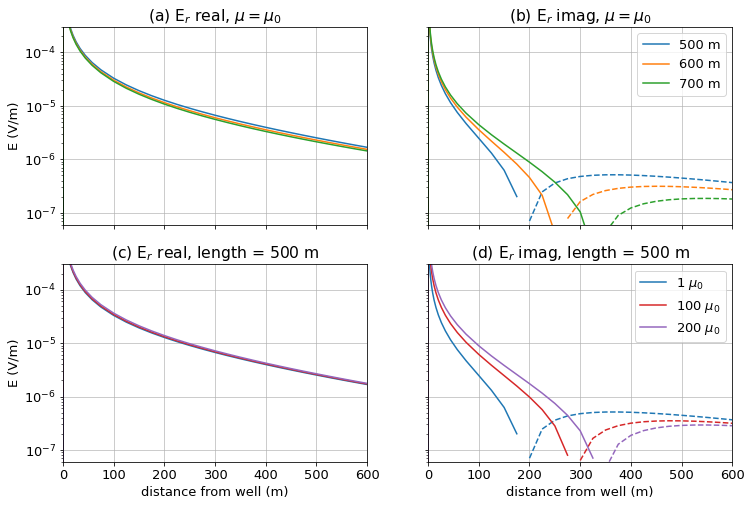

In [71]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

sigma_plot = 1e-1
mur_plot = [1, 100, 200]
freq_ind_plot = 2
print(frequencies[freq_ind_plot])

length_compare = 500
casing_l_plot = length_compare + np.r_[0, 100, 200]

# for j, mur in enumerate(mur_plot): 
j = 0
for i, key in enumerate([f"casing_1_{l:1.0f}" for l in casing_l_plot]):
    
    src_plot = fields[key].survey.source_list[freq_ind_plot]
    total = fields[key][src_plot, "e"][faces_perpendicular].squeeze()

    label = f"{key.split('_')[-1]} m"

    plot_pos_neg_log(mesh.nodes_x[1:], total.real, ax[j, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.nodes_x[1:], total.imag, ax[j, 1], plot_type="semilogy", color=f"C{i}", label=label)

    ax[j, 0].set_title(f"{key.split('_')[1]} $\mu_0$")


j = 1
for i, key in enumerate([f"casing_{mur}_{length_compare:1.0f}" for mur in mur_plot]):

    src_plot = fields[key].survey.source_list[freq_ind_plot]
    total = fields[key][src_plot, "e"][faces_perpendicular].squeeze()
    
    label = f"{key.split('_')[1]} $\mu_0$"

    color_i = 0 if i == 0 else i + len(casing_l_plot)-1
    plot_pos_neg_log(mesh.nodes_x[1:], total.real, ax[j, 0], plot_type="semilogy", color=f"C{color_i}", label=label)
    plot_pos_neg_log(mesh.nodes_x[1:], total.imag, ax[j, 1], plot_type="semilogy", color=f"C{color_i}", label=label)

    ax[j, 0].set_title(f"{length_compare:1.0f}m")



ax[0, 0].set_xlim([0, 600])
ax[0, 0].set_ylim([6e-8, 3e-4])
# for a in ax[0, :]:
#     a.set_ylim([2e-11, 6e-9])

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("E (V/m)")


for a in ax.flatten():
    a.grid(alpha=0.8)
    
ax[0, 1].legend()
ax[1, 1].legend()


ax[0, 0].set_title("(a) E$_r$ real, $\mu = \mu_0$")
ax[0, 1].set_title("(b) E$_r$ imag, $\mu = \mu_0$")

ax[1, 0].set_title(f"(c) E$_r$ real, length = ${length_compare:1.0f}$ m")
ax[1, 1].set_title(f"(d) E$_r$ imag, length = ${length_compare:1.0f}$ m")

ax[1, 0].set_xlabel("distance from well (m)")
ax[1, 1].set_xlabel("distance from well (m)")

# ax[0, 0].set_xlim([60, 225])

if save_figures: 
    fig.savefig(f"{fig_dir_high}/motivation-casing-integrity-500", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/motivation-casing-integrity-500", dpi=dpi_low, bbox_inches="tight")

In [66]:
save_figures = True

4.6


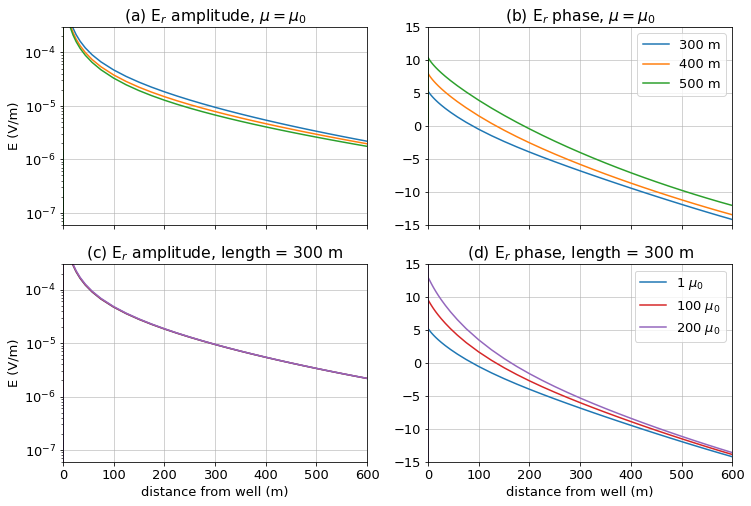

In [1406]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

sigma_plot = 1e-1
mur_plot = [1, 100,  200]
freq_ind_plot = 10
print(frequencies[freq_ind_plot])

casing_l_plot = casing_l[2:]

# for j, mur in enumerate(mur_plot): 
j = 0
for i, key in enumerate([f"casing_1_{l:1.0f}" for l in casing_l_plot]):
    
    src_plot = fields[key].survey.source_list[freq_ind_plot]
    total = fields[key][src_plot, "e"][faces_perpendicular].squeeze()

    label = f"{key.split('_')[-1]} m"
    
    amp, phase = get_amplitude_phase(total)
    ax[j, 0].semilogy(mesh.nodes_x[1:], amp, color=f"C{i}", label=label)
    ax[j, 1].plot(mesh.nodes_x[1:], phase, color=f"C{i}", label=label)

    ax[j, 0].set_title(f"{key.split('_')[1]} $\mu_0$")

ind_l = 2
length_compare = casing_l[ind_l]
j = 1
for i, key in enumerate([f"casing_{mur}_{length_compare:1.0f}" for mur in mur_plot]):

    src_plot = fields[key].survey.source_list[freq_ind_plot]
    total = fields[key][src_plot, "e"][faces_perpendicular].squeeze()
    
    label = f"{key.split('_')[1]} $\mu_0$"

    color_i = ind_l-2 if i == 0 else i + len(casing_l_plot)-1
    amp, phase = get_amplitude_phase(total)
    ax[j, 0].semilogy(mesh.nodes_x[1:], amp, color=f"C{color_i}", label=label)
    ax[j, 1].plot(mesh.nodes_x[1:], phase, color=f"C{color_i}", label=label)

    ax[j, 0].set_title(f"{length_compare:1.0f}m")



ax[0, 0].set_xlim([0, 600])

for a in ax[:, 0]: 
    a.set_ylim([6e-8, 3e-4])
for a in ax[:, 1]:
    a.set_ylim(15*np.r_[-1, 1])
# for a in ax[0, :]:
#     a.set_ylim([2e-11, 6e-9])

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("E (V/m)")


for a in ax.flatten():
    a.grid(alpha=0.7)
    
ax[0, 1].legend()
ax[1, 1].legend()


ax[0, 0].set_title("(a) E$_r$ amplitude, $\mu = \mu_0$")
ax[0, 1].set_title("(b) E$_r$ phase, $\mu = \mu_0$")

ax[1, 0].set_title(f"(c) E$_r$ amplitude, length = ${casing_l[ind_l]:1.0f}$ m")
ax[1, 1].set_title(f"(d) E$_r$ phase, length = ${casing_l[ind_l]:1.0f}$ m")

ax[1, 0].set_xlabel("distance from well (m)")
ax[1, 1].set_xlabel("distance from well (m)")

# ax[0, 0].set_xlim([60, 225])

if save_figures: 
    fig.savefig(f"{fig_dir_high}/motivation-casing-integrity-amplitude-phase", dpi=dpi_high, bbox_inches="tight")
    fig.savefig(f"{fig_dir_low}/motivation-casing-integrity-amplitude-phase", dpi=dpi_low, bbox_inches="tight")

In [1412]:
frequencies[10]

4.6

In [1413]:
mesh.cell_centers_z[117]

-2.499999999999716

In [1428]:
zind = 117
src_ind = 10

inds_faces_x = (mesh.faces_x[:, 2] == mesh.cell_centers_z[117])

inds_er_surface = np.hstack([
    inds_faces_x,
    np.zeros(mesh.n_faces_y, dtype=bool), np.zeros(mesh.n_faces_z, dtype=bool)
]) 

In [1485]:
from matplotlib.lines import Line2D

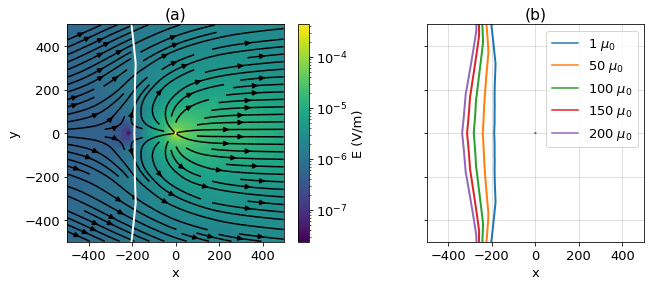

In [1499]:
fig, ax = plt.subplots(1, 2, figsize=(11, 4), sharex=True, sharey=True)

casing_l = 500
key = f"casing_1_{casing_l}"

xlim=500*np.r_[-1, 1]
src_ind= 10
zind = 117

f = fields[key]
src = f.survey.source_list[src_ind]
eradial = f[src, "e"][inds_er_surface]

faces_x_cartesian = mesh.cartesian_grid("Fx", theta_shift=0.5*mesh.hy[0])[inds_faces_x]

faces_x = faces_x_cartesian[:, 0].reshape(
    mesh.nodes_x[1:].shape[0], mesh.cell_centers_y.shape[0], order="F"
)

faces_y = faces_x_cartesian[:, 1].reshape(
    mesh.nodes_x[1:].shape[0], mesh.cell_centers_y.shape[0], order="F"
)

e_radial = eradial.reshape(
    mesh.nodes_x[1:].shape[0], mesh.cell_centers_y.shape[0], order="F"
)

out = casing_sim.view.plot_depth_slice(
    f,
    view="e",
    src_ind=src_ind,
    xlim=xlim,
    ylim=xlim,
    z_ind=zind, 
    theta_shift=0.5*mesh.hy[0],
    ax=ax[0], 
    # clim=clim,
    # show_cb=False,
    k=30,
    component="vec",
    real_or_imag="imag",
    # stream_opts=stream_opts
)

cb = out[-1]
cb.set_label("E (V/m)")
ax[0].contour(faces_x, faces_y, e_radial.imag, [0], colors=["w"], linewidths=[2])

for i, mur in enumerate(mur_casing):
    key = f"casing_{mur}_{casing_l}"
    f = fields[key]
    src = f.survey.source_list[src_ind]
    eradial = f[src, "e"][inds_er_surface]
    
    e_radial = eradial.reshape(
        mesh.nodes_x[1:].shape[0], mesh.cell_centers_y.shape[0], order="F"
    )
    ax[1].contour(faces_x, faces_y, e_radial.imag, [0], colors=[f"C{i}"], linewidths=[2])

lines = [Line2D([0], [0], color=f"C{i}") for i in range(len(mur_casing))]
ax[1].legend(handles=lines, labels=[f"{mur} $\mu_0$" for mur in mur_casing])
ax[1].grid("both", alpha=0.5)
ax[1].set_xlabel("x")

for a in ax:
    a.set_aspect(1)
    a.set_title("")

ax[0].set_title("(a)")
ax[1].set_title("(b)")


if save_figures: 
    fig.savefig(f"{fig_dir_high}/zero-crossing-permeability", dpi=dpi_high, bbox_inches="tight")
    fig.savefig( f"{fig_dir_low}/zero-crossing-permeability", dpi=dpi_low, bbox_inches="tight")

In [ ]:

fig, ax = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=True)

sigma_plot = 1e-1
mur_plot = [1, 100,  200]
freq_ind_plot = 10
print(frequencies[freq_ind_plot])

casing_l_plot = casing_l[-1]

# for j, mur in enumerate(mur_plot): 
j = 0

non_permeable_key = f"casing_{mur}_{casing_l_plot:1.0f}"


for i, mur in enumerate(mur_plot):
    
    permeable_key = f"casing_{mur}_{casing_l_plot:1.0f}"
    src_plot_permeable = fields[permeable_key].survey.source_list[freq_ind_plot]
    permeable = fields[permeable_key][src_plot_permeable, "e"][faces_perpendicular].squeeze()
    label_permeable = f"{mur} $\mu_0$"
    
    if mur == 1: 
        conductive_key = permeable_key
        color_ind = i
    else: 
        conductive_key = f"conductive_casing_{sigma_casing*mur:1.2e}_{casing_l_plot:1.0f}"
        color_ind = i+2
    src_plot_conductive = fields[conductive_key].survey.source_list[freq_ind_plot]
    conductive = fields[conductive_key][src_plot_conductive, "e"][faces_perpendicular].squeeze()
    label_conductive = f"{mur*sigma_casing:1.0e} S/m"

    plot_pos_neg_log(mesh.nodes_x[1:], permeable.real, ax[0, 0], plot_type="semilogy", color=f"C{i}", label=label_permeable)
    plot_pos_neg_log(mesh.nodes_x[1:], permeable.imag, ax[0, 1], plot_type="semilogy", color=f"C{i}", label=label_permeable)
    
    plot_pos_neg_log(mesh.nodes_x[1:], conductive.real, ax[1, 0], plot_type="semilogy", color=f"C{color_ind}", label=label_conductive)
    plot_pos_neg_log(mesh.nodes_x[1:], conductive.imag, ax[1, 1], plot_type="semilogy", color=f"C{color_ind}", label=label_conductive)



ax[0, 0].set_xlim([0, 600])

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("E (V/m)")


for a in ax.flatten():
    a.grid(alpha=0.7)
    
ax[0, 1].legend()
ax[1, 1].legend()

for a in ax.flatten():
    a.set_ylim(4e-8, 3e-4)

ax[0, 0].set_title(f"(a) E real, conductive & permeable ({frequencies[freq_ind_plot]} Hz)")
ax[0, 1].set_title(f"(b) E imag, conductive & permeable ({frequencies[freq_ind_plot]} Hz)")

ax[1, 0].set_title(f"(c) E real, conductive")
ax[1, 1].set_title(f"(d) E imag, conductive")

ax[1, 0].set_xlabel("distance from well (m)")
ax[1, 1].set_xlabel("distance from well (m)")

0.22


Text(0.5, 1.0, 'E imag')

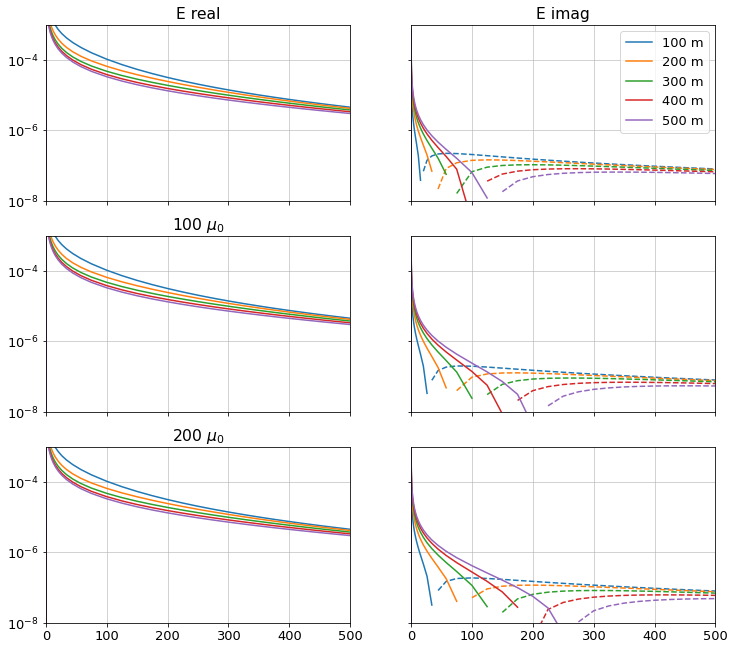

In [214]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True, sharey=True)

sigma_plot = 1e-1
mur_plot = [1, 100, 200]
freq_ind_plot = 2
print(frequencies[freq_ind_plot])

for j, mur in enumerate(mur_plot): 
    for i, key in enumerate([f"casing_{mur}_{l:1.0f}" for l in casing_l]):
        src_plot = fields[key].survey.source_list[freq_ind_plot]
        total = fields[key][src_plot, "e"][inds_plot].squeeze()

        label = f"{key.split('_')[-1]} m"

        plot_pos_neg_log(mesh.nodes_x[1:], total.real, ax[j, 0], plot_type="semilogy", color=f"C{i}", label=label)
        plot_pos_neg_log(mesh.nodes_x[1:], total.imag, ax[j, 1], plot_type="semilogy", color=f"C{i}", label=label)

        ax[j, 0].set_title(f"{key.split('_')[1]} $\mu_0$")
ax[0, 0].set_xlim([0, 500])
ax[0, 0].set_ylim([1e-8, 1e-3])
# for a in ax[0, :]:
#     a.set_ylim([2e-11, 6e-9])

# for a in ax[1, :]:
#     a.set_ylim([6e-15, 1e-10])

# for a in ax[2, :]:
#     a.set_ylim([9e-3, 3e1])

for a in ax.flatten():
    a.grid(alpha=0.7)
    
ax[0, 1].legend()
ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")


0.22


Text(0.5, 1.0, 'B imag')

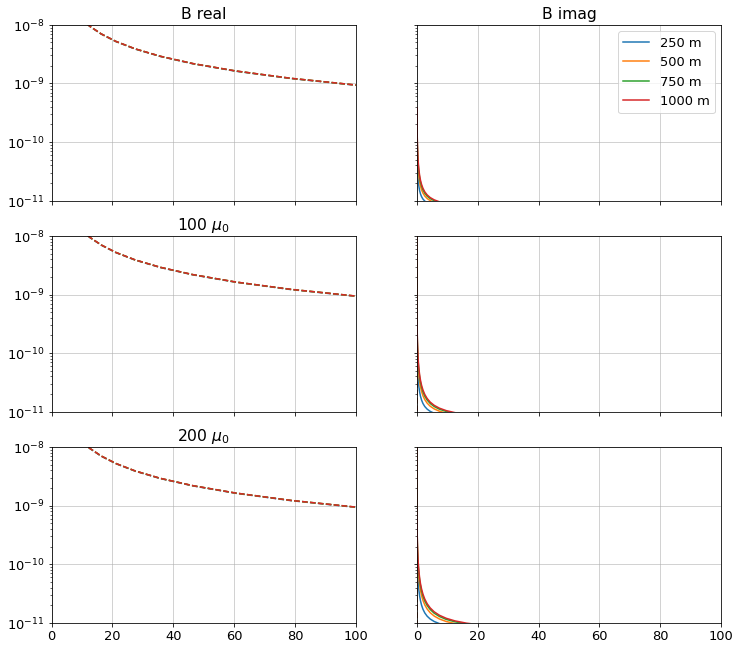

In [68]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True, sharey=True)

sigma_plot = 1e-1
mur_plot = [1, 100, 200]
freq_ind_plot = 2
print(frequencies[freq_ind_plot])

component = "y"

if component == "x":
    inds_plot = cell_centers_plot
elif component == "y":
    inds_plot = cell_centers_plot + mesh.n_cells
elif component == "z":
    inds_plot = cell_centers_plot + mesh.n_cells*2

for j, mur in enumerate(mur_plot): 
    for i, key in enumerate([f"casing_{mur}_{l:1.0f}" for l in casing_l]):

        total = cell_centered_b[key][inds_plot, freq_ind_plot]

        label = f"{key.split('_')[-1]} m"

        plot_pos_neg_log(mesh.cell_centers_x, total.real, ax[j, 0], plot_type="semilogy", color=f"C{i}", label=label)
        plot_pos_neg_log(mesh.cell_centers_x, total.imag, ax[j, 1], plot_type="semilogy", color=f"C{i}", label=label)

        ax[j, 0].set_title(f"{key.split('_')[1]} $\mu_0$")
ax[0, 0].set_xlim([0, 100])
ax[0, 0].set_ylim([1e-11, 1e-8])
# for a in ax[0, :]:
#     a.set_ylim([2e-11, 6e-9])

# for a in ax[1, :]:
#     a.set_ylim([6e-15, 1e-10])

# for a in ax[2, :]:
#     a.set_ylim([9e-3, 3e1])

for a in ax.flatten():
    a.grid(alpha=0.7)
    
ax[0, 1].legend()
ax[0, 0].set_title("B real")
ax[0, 1].set_title("B imag")


0.15


Text(0.5, 1.0, 'B imag')

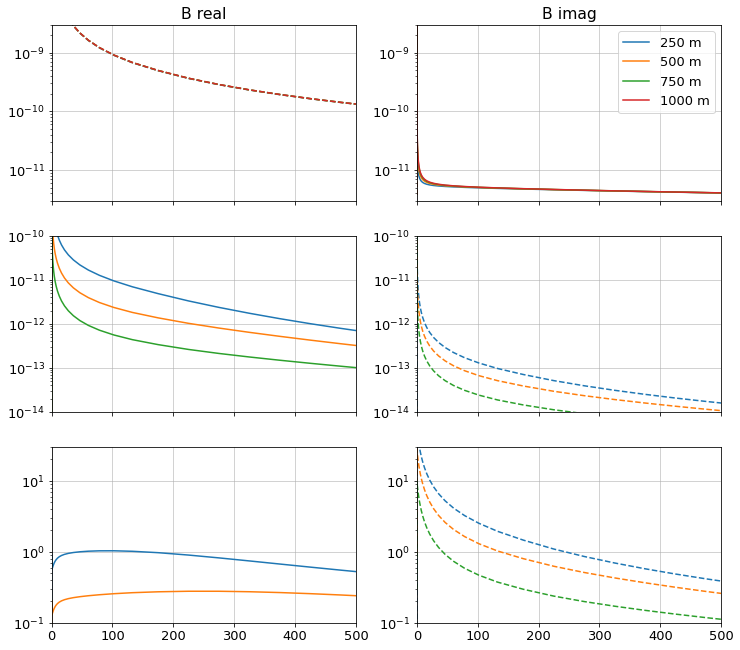

In [69]:
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

sigma_plot = 1e-1
mur_plot = 100
freq_ind_plot = 1
print(frequencies[freq_ind_plot])
primary_length = 1000

primary_key = f"casing_{mur_plot}_{primary_length:1.0f}"

component = "y"

if component == "x":
    inds_plot = cell_centers_plot
elif component == "y":
    inds_plot = cell_centers_plot + mesh.n_cells
elif component == "z":
    inds_plot = cell_centers_plot + mesh.n_cells*2

primary = cell_centered_b[primary_key][inds_plot, freq_ind_plot]


for i, key in enumerate([f"casing_{mur_plot}_{l:1.0f}" for l in casing_l]):

    total = cell_centered_b[key][inds_plot, freq_ind_plot]
    diff = total - primary

    label = f"{key.split('_')[-1]} m"

    plot_pos_neg_log(mesh.cell_centers_x, total.real, ax[0, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.cell_centers_x, total.imag, ax[0, 1], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.cell_centers_x, diff.real, ax[1, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.cell_centers_x, diff.imag, ax[1, 1], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.cell_centers_x, diff.real/np.abs(primary.real) * 100, ax[2, 0], plot_type="semilogy", color=f"C{i}", label=label)
    plot_pos_neg_log(mesh.cell_centers_x, diff.imag/np.abs(primary.imag) * 100, ax[2, 1], plot_type="semilogy", color=f"C{i}", label=label)

ax[0, 0].set_xlim([0, 500])
# ax[0, 0].set_ylim([1e-11, 1e-8])
for a in ax[0, :]:
    a.set_ylim([3e-12, 3e-9])

for a in ax[1, :]:
    a.set_ylim([1e-14, 1e-10])

for a in ax[2, :]:
    a.set_ylim([1e-1, 3e1])

for a in ax.flatten():
    a.grid(alpha=0.7)
    
ax[0, 1].legend()
ax[0, 0].set_title("B real")
ax[0, 1].set_title("B imag")


In [131]:
models.keys()

dict_keys(['halfspace', 'casing_1_100', 'casing_50_100', 'casing_100_100', 'casing_150_100', 'casing_200_100', 'casing_1_200', 'casing_50_200', 'casing_100_200', 'casing_150_200', 'casing_200_200', 'casing_1_300', 'casing_50_300', 'casing_100_300', 'casing_150_300', 'casing_200_300', 'casing_1_400', 'casing_50_400', 'casing_100_400', 'casing_150_400', 'casing_200_400', 'casing_1_500', 'casing_50_500', 'casing_100_500', 'casing_150_500', 'casing_200_500', 'conductive_casing_2.50e+08_100', 'conductive_casing_5.00e+08_100', 'conductive_casing_7.50e+08_100', 'conductive_casing_1.00e+09_100', 'conductive_casing_2.50e+08_200', 'conductive_casing_5.00e+08_200', 'conductive_casing_7.50e+08_200', 'conductive_casing_1.00e+09_200', 'conductive_casing_2.50e+08_300', 'conductive_casing_5.00e+08_300', 'conductive_casing_7.50e+08_300', 'conductive_casing_1.00e+09_300', 'conductive_casing_2.50e+08_400', 'conductive_casing_5.00e+08_400', 'conductive_casing_7.50e+08_400', 'conductive_casing_1.00e+09_400

In [ ]:
length = {}

In [140]:
xlocs = np.r_[30, 57, 58, 60, 65, 75]
mesh.nodes_x[xlocs]

array([1.10146714e-01, 7.50000000e+01, 1.00000000e+02, 1.50000000e+02,
       2.75000000e+02, 5.25000000e+02])

In [253]:
zloc = -csz/2
theta_loc = 3

face_inds = np.zeros_like(xlocs)

for i, xl in enumerate(xlocs):
    face_inds[i] = np.where(
        (mesh.faces_x[:, 0] == mesh.vectorNx[xl]) &
        (mesh.faces_x[:, 1] == mesh.vectorCCy[theta_loc]) & 
        (np.abs(mesh.faces_x[:, 2] - zloc) == np.min(np.abs(mesh.faces_x[:, 2] - zloc)))
    )[0]
    print(mesh.faces_x[face_inds[i], :])

[ 0.11014671  1.83259571 -2.5       ]
[75.          1.83259571 -2.5       ]
[100.           1.83259571  -2.5       ]
[150.           1.83259571  -2.5       ]
[275.           1.83259571  -2.5       ]
[525.           1.83259571  -2.5       ]


/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vectorNx has been deprecated, please use CylindricalMesh.nodes_x. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)
/home/lheagy/git/simpeg/discretize/discretize/utils/code_utils.py:182: FutureWarning: CylindricalMesh.vectorCCy has been deprecated, please use CylindricalMesh.cell_centers_y. It will be removed in version 1.0.0 of discretize.
  warnings.warn(message, Warning)


In [254]:
models.keys()

dict_keys(['halfspace', 'casing_1_100', 'casing_50_100', 'casing_100_100', 'casing_150_100', 'casing_200_100', 'casing_1_200', 'casing_50_200', 'casing_100_200', 'casing_150_200', 'casing_200_200', 'casing_1_300', 'casing_50_300', 'casing_100_300', 'casing_150_300', 'casing_200_300', 'casing_1_400', 'casing_50_400', 'casing_100_400', 'casing_150_400', 'casing_200_400', 'casing_1_500', 'casing_50_500', 'casing_100_500', 'casing_150_500', 'casing_200_500', 'conductive_casing_2.50e+08_100', 'conductive_casing_5.00e+08_100', 'conductive_casing_7.50e+08_100', 'conductive_casing_1.00e+09_100', 'conductive_casing_2.50e+08_200', 'conductive_casing_5.00e+08_200', 'conductive_casing_7.50e+08_200', 'conductive_casing_1.00e+09_200', 'conductive_casing_2.50e+08_300', 'conductive_casing_5.00e+08_300', 'conductive_casing_7.50e+08_300', 'conductive_casing_1.00e+09_300', 'conductive_casing_2.50e+08_400', 'conductive_casing_5.00e+08_400', 'conductive_casing_7.50e+08_400', 'conductive_casing_1.00e+09_400

[100.           1.83259571  -2.5       ]


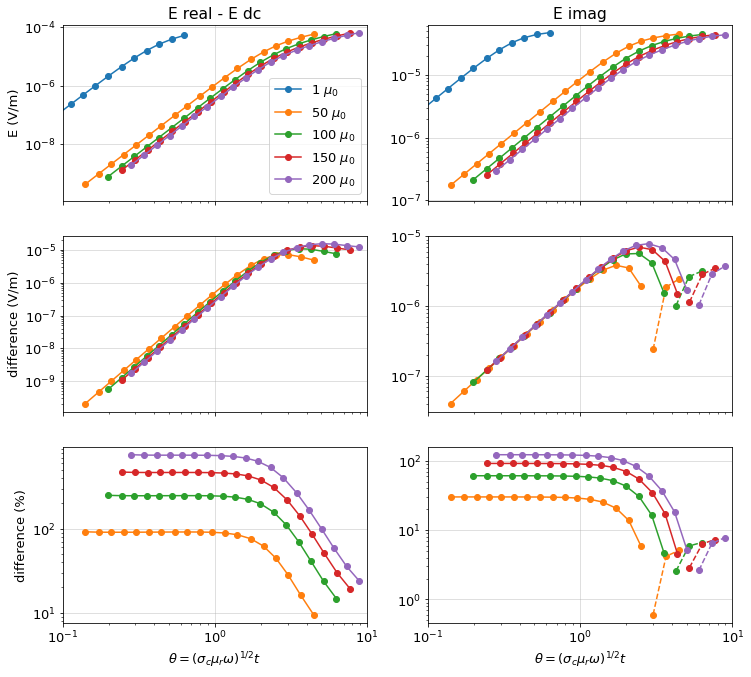

In [271]:
fi = 2
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

print(mesh.faces_x[face_inds[fi]])
sigma_plot = 1
l_plot = 500
primary_key = f"casing_1_{l_plot}"
mur_plot = mur_casing
primary = fields[primary_key][:, "e"][face_inds[fi]]

subtract_dc = True

if subtract_dc is True:
    primary = primary - fields_dc[primary_key][:, "e"][face_inds[fi]]

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]

x = frequencies

for i, mur in enumerate(mur_casing):
    key = f"casing_{mur}_{l_plot}"
    total = fields[key][:, "e"][face_inds[fi]]
    
    x = np.sqrt(sigma_casing * mur * mu_0 * 2 * np.pi * frequencies) * casing_t
    
    if subtract_dc is True:
        total = total - fields_dc[primary_key][:, "e"][face_inds[fi]]
    diff = total - primary
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    plot_pos_neg_log(x, total.real, ax[0, 0], plot_type="loglog", marker="o", color=f"C{i}", label=label)
    plot_pos_neg_log(x, total.imag, ax[0, 1], plot_type="loglog", marker="o", color=f"C{i}", label=label)
    plot_pos_neg_log(x, diff.real, ax[1, 0], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    plot_pos_neg_log(x, diff.imag, ax[1, 1], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    plot_pos_neg_log(x, diff.real/np.abs(primary.real)*100, ax[2, 0], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    plot_pos_neg_log(x, diff.imag/np.abs(primary.imag)*100, ax[2, 1], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)
    
if subtract_dc:
    ax[0, 0].set_title("E real - E dc")
else: 
    ax[0, 0].set_title("E real")
ax[0, 1].set_title("E imag")

ax[0, 0].set_ylabel("E (V/m)")
ax[1, 0].set_ylabel("difference (V/m)")
ax[2, 0].set_ylabel("difference (%)")
# for a in ax[0, :].flatten():
#     a.set_ylim([1e-7, 2e-4])
    
# for a in ax[1, :].flatten():
#     a.set_ylim([1e-10, 3e-5])

# for a in ax[2, :].flatten():
#     a.set_ylim([1e-3, 2e2])
# for a in ax[1, :]:
#     a.set_ylim(1e-5*np.r_[-1, 2])
# for a in ax[:2, 0].flatten():
#     a.set_ylim(re_ylim)

# for a in ax[:2, 1].flatten():
#     a.set_ylim(im_ylim)

ax[0, 0].set_xlim(1e-1, 1e1) 
ax[0, 0].legend(loc=0)

for a in ax[2, :]: 
    a.set_xlabel("$\\theta = (\sigma_c \mu_r \omega)^{1/2}t$")

In [258]:
def get_amplitude_phase(f):
    real = f.real
    imag = f.imag
    amplitude = np.sqrt(real**2 + imag**2)
    phase = 180/np.pi*np.arctan2(imag, real)
    return amplitude, phase

Text(0.5, 1.0, 'Phase ($\\degree$)')

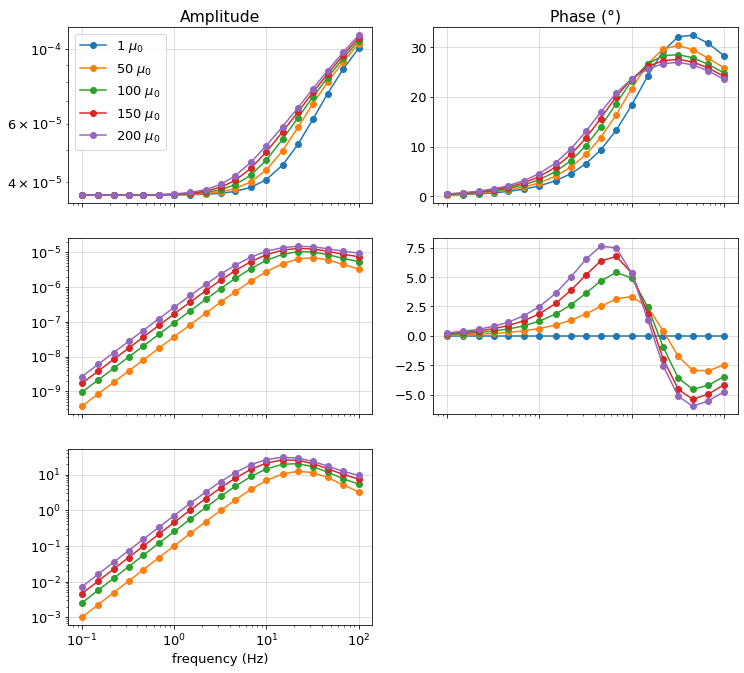

In [259]:
fi = 2
fig, ax = plt.subplots(3, 2, figsize=(12, 11), sharex=True)

sigma_plot = 1e-1
l_plot = 500
primary_key = f"casing_1_{l_plot}"
mur_plot = mur_casing
primary = fields[primary_key][:, "e"][face_inds[fi]]
a_primary, p_primary = get_amplitude_phase(primary)
subtract_dc = False

if subtract_dc is True:
    primary = primary - fields_dc[primary_key][:, "e"][face_inds[fi]]

re_ylim = 1e-5*np.r_[-1, 12]
im_ylim = 1e-6*np.r_[-1, 30]


for i, key in enumerate([f"casing_{mur}_{l_plot}" for mur in mur_casing]):
    total = fields[key][:, "e"][face_inds[fi]]
    a_total, p_total = get_amplitude_phase(total)
    a_diff, p_diff = (a_total - a_primary), (p_total - p_primary)
    
    label = f"{key.split('_')[-2]} $\mu_0$"
    ax[0, 0].loglog(frequencies, a_total, "-o", color=f"C{i}", label=label)
    ax[0, 1].semilogx(frequencies, p_total, "-o", color=f"C{i}", label=label)
    
    plot_pos_neg_log(frequencies, a_diff, ax[1, 0], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    ax[1, 1].semilogx(frequencies, p_diff, marker="o", color=f"C{i}", label=None)
    
    plot_pos_neg_log(frequencies, a_diff/a_primary*100, ax[2, 0], plot_type="loglog", marker="o", color=f"C{i}", label=None)
    
for a in ax.flatten():
    a.grid("both", alpha=0.5)

for a in ax.flatten():
    a.grid("both", alpha=0.5)
# for a in ax[0, :].flatten():
#     a.set_ylim([1e-7, 2e-4])
    
# for a in ax[1, :].flatten():
#     a.set_ylim([1e-10, 3e-5])

# for a in ax[2, :].flatten():
#     a.set_ylim([1e-3, 2e2])
# for a in ax[1, :]:
#     a.set_ylim(1e-5*np.r_[-1, 2])
# for a in ax[:2, 0].flatten():
#     a.set_ylim(re_ylim)

# for a in ax[:2, 1].flatten():
#     a.set_ylim(im_ylim)
    
ax[0, 0].legend(loc=0)
ax[2, 1].axis("off")
ax[2, 0].set_xlabel("frequency (Hz)")

ax[0, 0].set_title("Amplitude")
ax[0, 1].set_title("Phase ($\degree$)")

In [379]:
key = "casing_200_500"

e = fields[key][:, "e"]
j = fields[key][:, "j"]
sim = fields[key].simulation

In [313]:
# mu_sigma_averaged = mesh.aveF2CC.T * (sim.mu * sim.sigma)
ln_mur_averaged = np.log(sim.mu / mu_0)

In [316]:
np.kron( np.r_[1, 1], np.r_[1,2,3])

array([1, 2, 3, 1, 2, 3])

In [392]:
wavenumber_term = 2*np.pi*1j*frequencies* (
    mesh.average_face_to_cell_vector * (sim.MfI * (mesh.get_face_inner_product(sim.mu) * j))
)

In [383]:
not_hanging_faces = np.hstack([
    ~getattr(mesh, f"_ishanging_faces_{coord}_bool") for coord in ["x", "y", "z"]
])

In [384]:
curl_e_term = mesh.average_edge_to_cell_vector * (mesh.edge_curl.T * e)
ln_mu_term = (
    mesh.average_face_to_cell_vector * 
    (mesh._face_divergence_stencil.T * np.log(sim.mu / mu_0))[not_hanging_faces]
)

In [385]:
curl_e_x = curl_e_term[:mesh.n_cells, :]
curl_e_y = curl_e_term[mesh.n_cells:2*mesh.n_cells, :]
curl_e_z = curl_e_term[2*mesh.n_cells:, :]

ln_mu_x = ln_mu_term[:mesh.n_cells]
ln_mu_y = ln_mu_term[mesh.n_cells:2*mesh.n_cells]
ln_mu_z = ln_mu_term[2*mesh.n_cells:]

cross_x = discretize.utils.sdiag(ln_mu_y) * curl_e_z - discretize.utils.sdiag(ln_mu_z) * curl_e_y
cross_y = discretize.utils.sdiag(ln_mu_z) * curl_e_x - discretize.utils.sdiag(ln_mu_x) * curl_e_z
cross_z = discretize.utils.sdiag(ln_mu_x) * curl_e_y - discretize.utils.sdiag(ln_mu_y) * curl_e_x

cross_term = - np.vstack([cross_x, cross_y, cross_z])

In [396]:
curl_curl_e = mesh.average_face_to_cell_vector * (mesh.edge_curl * (mesh.edge_curl.T * e))

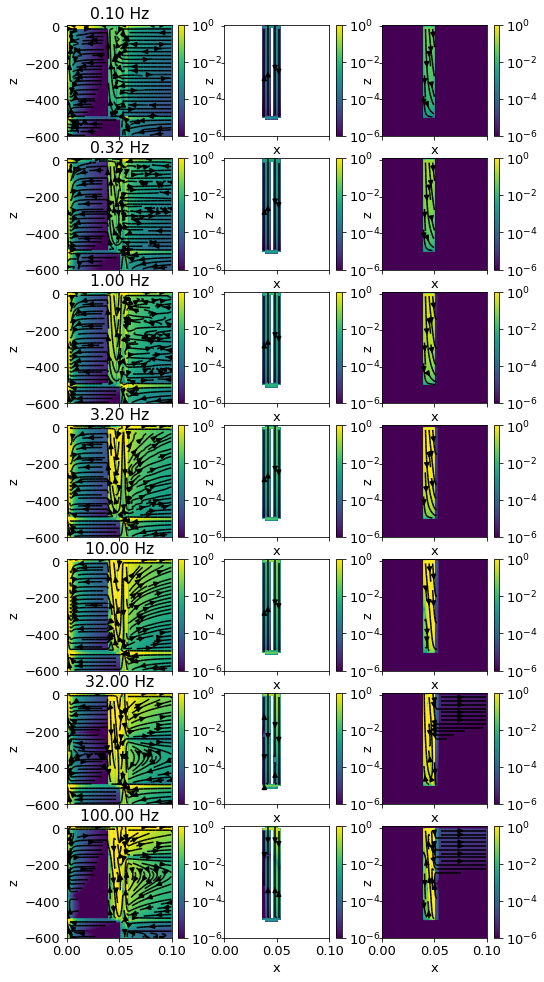

In [401]:
fig, ax = plt.subplots(
    len(freq_inds_plot), 3, figsize=(8, (len(freq_inds_plot))*2.4),
    sharex=True, sharey=True
)

xlim = 0.1*np.r_[0, 1]
zlim = np.r_[-600, 10]
clim = np.r_[1e-6, 1e0]
reim = "imag"

for i, freq_ind in enumerate(freq_inds_plot):
    plot_cell_centered_vector(
        getattr(curl_curl_e[:, freq_ind], reim), 
        theta_ind=3, ax=ax[i, 0], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        getattr(cross_term[:, freq_ind], reim), 
        theta_ind=3, ax=ax[i, 1], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        getattr(wavenumber_term[:, freq_ind], reim), 
        theta_ind=3, ax=ax[i, 2], xlim=xlim, zlim=zlim,
        log_scale=True, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    ax[i, 0].set_title(f"{frequencies[freq_ind]:1.2f} Hz")
    ax[i, 0].set_xlabel("")

In [406]:
def add_circle(ax, radius, color="k", ls="-"):
    x = np.linspace(-radius, radius, 100)
    top = np.sqrt(radius**2 - x**2)
    ax.plot(x, top, color=color, ls=ls)
    ax.plot(x, -top, color=color, ls=ls)

In [443]:
frequencies

array([  0.1 ,   0.15,   0.22,   0.32,   0.46,   0.68,   1.  ,   1.5 ,
         2.2 ,   3.2 ,   4.6 ,   6.8 ,  10.  ,  15.  ,  22.  ,  32.  ,
        46.  ,  68.  , 100.  ])

In [484]:
mesh.cell_centers_z[97]

-102.49999999999972

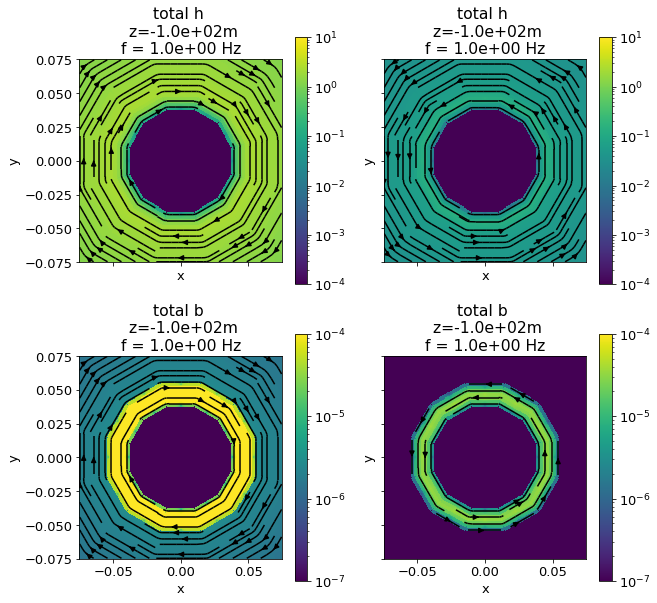

In [486]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
key = "casing_200_500"
primary_key = "casing_1_500"
f = fields[key]
xlim=0.075*np.r_[-1, 1]
src_ind=6
zind = 97

for i, view in enumerate(["h", "b"]):
    if view == "h":
        clim = np.r_[1e-4, 10]
    elif view == "b":
        clim = np.r_[1e-7, 1e-4]
    for j, reim in enumerate(["real", "imag"]):
        out = casing_sim.view.plot_depth_slice(
            f,
            view=view,
            primary_fields=fields[primary_key],
            prim_sec="total",
            src_ind=src_ind,
            xlim=xlim,
            ylim=xlim,
            z_ind=zind, 
            theta_shift=0.5*mesh.hy[0],
            ax=ax[i, j], 
            clim=clim,
            # show_cb=False,
            k=3,
            component="vec",
            real_or_imag=reim,
            # stream_opts=stream_opts
        )
        # add_circle(ax[i, j], casing_a, color="C3")
        # add_circle(ax[i, j], casing_b, color="C3")
        ax[i, j].set_aspect(1)
        # ax[i, j].set_title(f"{view.upper()}, {reim}")

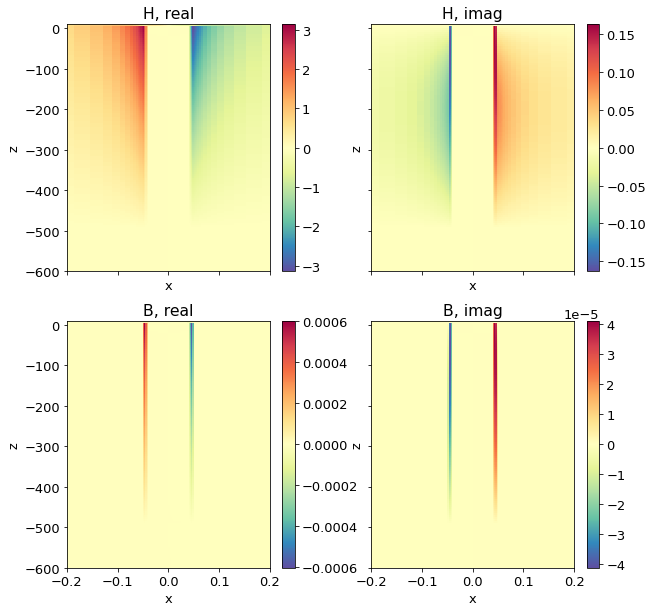

In [557]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
key = "casing_200_500"
f = fields[key]
xlim=0.2*np.r_[-1, 1]
src_ind=6
zind = 67

fields_plot = fields[key]
src_plot = fields_plot.survey.source_list[src_ind]

for i, view in enumerate(["h", "b"]):
    if view == "h":
        clim = np.r_[1e-4, 10]
    elif view == "b":
        clim = np.r_[1e-7, 1e-4]
    for j, reim in enumerate(["real", "imag"]):
        
        plot_cell_centered_vector(
            getattr(fields_plot[src_plot, view], reim), 
            theta_ind=3, ax=ax[i, j], xlim=xlim, zlim=zlim,
            log_scale=False, #vmin=clim.min(), clim=clim,
            component="y", show_colorbar=True,
            stream_opts=None
        )
        ax[i, j].set_title(f"{view.upper()}, {reim}")

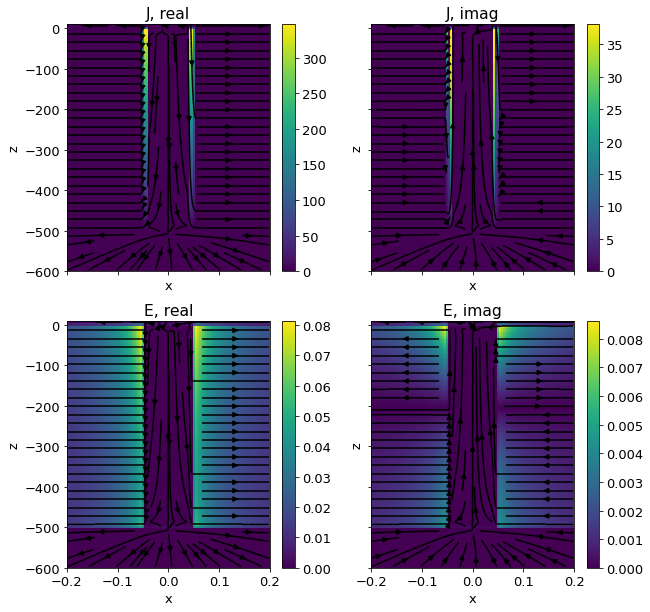

In [558]:
fig, ax = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(10, 10))
key = "casing_200_500"
f = fields[key]
xlim=0.2*np.r_[-1, 1]
src_ind=6
zind = 67

fields_plot = fields[key]
src_plot = fields_plot.survey.source_list[src_ind]

for i, view in enumerate(["j", "e"]):
    # if view == "h":
    #     clim = np.r_[1e-4, 10]
    # elif view == "b":
    #     clim = np.r_[1e-7, 1e-4]
    for j, reim in enumerate(["real", "imag"]):
        
        plot_cell_centered_vector(
            getattr(fields_plot[src_plot, view], reim), 
            theta_ind=3, ax=ax[i, j], xlim=xlim, zlim=zlim,
            log_scale=False, #vmin=clim.min(), clim=clim,
            component="xz", show_colorbar=True,
            stream_opts=None
        )
        ax[i, j].set_title(f"{view.upper()}, {reim}")

In [491]:
mesh.nodes_z[98]

-99.99999999999972

In [492]:
mur_casing

array([  1,  50, 100, 150, 200])

In [494]:
fields.keys()

dict_keys(['halfspace', 'casing_1_100', 'casing_50_100', 'casing_100_100', 'casing_150_100', 'casing_200_100', 'casing_1_200', 'casing_50_200', 'casing_100_200', 'casing_150_200', 'casing_200_200', 'casing_1_300', 'casing_50_300', 'casing_100_300', 'casing_150_300', 'casing_200_300', 'casing_1_400', 'casing_50_400', 'casing_100_400', 'casing_150_400', 'casing_200_400', 'casing_1_500', 'casing_50_500', 'casing_100_500', 'casing_150_500', 'casing_200_500', 'conductive_casing_2.50e+08_100', 'conductive_casing_5.00e+08_100', 'conductive_casing_7.50e+08_100', 'conductive_casing_1.00e+09_100', 'conductive_casing_2.50e+08_200', 'conductive_casing_5.00e+08_200', 'conductive_casing_7.50e+08_200', 'conductive_casing_1.00e+09_200', 'conductive_casing_2.50e+08_300', 'conductive_casing_5.00e+08_300', 'conductive_casing_7.50e+08_300', 'conductive_casing_1.00e+09_300', 'conductive_casing_2.50e+08_400', 'conductive_casing_5.00e+08_400', 'conductive_casing_7.50e+08_400', 'conductive_casing_1.00e+09_400

In [498]:
frequencies[10]

4.6

In [1080]:
hc.shape, fields_plot.simulation.mu.shape

((89, 1), (150120,))

In [1083]:
avx.shape

(89, 90)

In [1086]:
fields_plot.simulation.mu[inds_mu_plot]

array([1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       2.51327412e-04, 2.51327412e-04, 2.51327412e-04, 2.51327412e-04,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
       1.25663706e-06, 1.25663706e-06, 1.25663706e-06, 1.25663706e-06,
      

In [1088]:
key

'casing_200_500'

In [1090]:
fields[key].simulation.mu.max()/mu_0

200.0

In [1099]:
key

'casing_200_500'

In [1100]:
fields[key].simulation.mu.max()

0.000251327412424

In [1095]:
np.where(fields[key].simulation.mu == fields[key].simulation.mu.max())

(array([ 19456,  19457,  19458, ..., 127367, 127368, 127369]),)

In [1096]:
inds_mu_plot

array([106110, 106111, 106112, 106113, 106114, 106115, 106116, 106117,
       106118, 106119, 106120, 106121, 106122, 106123, 106124, 106125,
       106126, 106127, 106128, 106129, 106130, 106131, 106132, 106133,
       106134, 106135, 106136, 106137, 106138, 106139, 106140, 106141,
       106142, 106143, 106144, 106145, 106146, 106147, 106148, 106149,
       106150, 106151, 106152, 106153, 106154, 106155, 106156, 106157,
       106158, 106159, 106160, 106161, 106162, 106163, 106164, 106165,
       106166, 106167, 106168, 106169, 106170, 106171, 106172, 106173,
       106174, 106175, 106176, 106177, 106178, 106179, 106180, 106181,
       106182, 106183, 106184, 106185, 106186, 106187, 106188, 106189,
       106190, 106191, 106192, 106193, 106194, 106195, 106196, 106197,
       106198, 106199])

In [1104]:
fields_plot.simulation.mu[
    inds_mu_plot
].max()/mu_0

200.0

Text(0.5, 0, 'radius (m)')

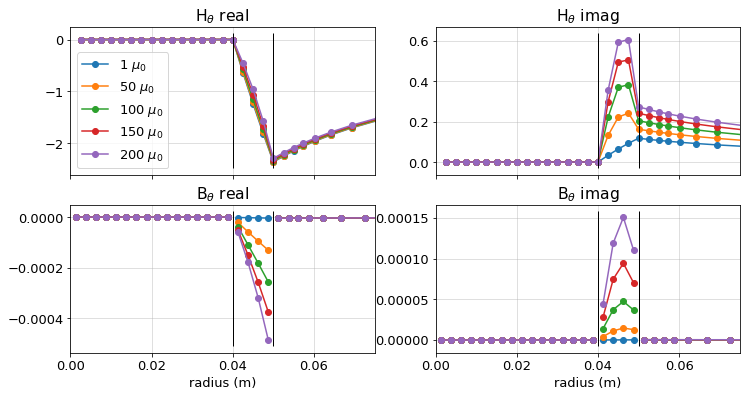

In [1251]:
fig, ax = plt.subplots(2, 2, sharex=True, figsize=(12, 6))
xlim = np.r_[0, 0.075]
theta_ind = 3
z_ind = 98
mur_plot = mur_casing
l_plot = 500
src_ind = 10

plot_keys = [f"casing_{mur}_{l_plot}" for mur in mur_casing]

inds_plot = np.where(
    (mesh.edges_y[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.edges_y[:, 2] == mesh.nodes_z[z_ind])
)[0] + mesh.n_edges_x 

inds_mu_plot = (
    (mesh.cell_centers[:, 1] == mesh.cell_centers_y[theta_ind]) & 
    (mesh.cell_centers[:, 2] == mesh.cell_centers_z[z_ind])
)

avx = discretize.utils.av(len(mesh.nodes_x[1:]))

for i, key in enumerate(plot_keys):
    label = f"{key.split('_')[1]} $\mu_0$"
    
    fields_plot=fields[key]
    src_plot=fields_plot.survey.source_list[src_ind]
    # b = fields_plot[src_plot, "b"][inds_plot]
    h = fields_plot[src_plot, "h"][inds_plot].squeeze()
    hc = avx * np.hstack([np.r_[0], h])
    bc = fields_plot.simulation.mu[inds_mu_plot] * hc
    # bc = discretize.utils.av(mesh.nodes
    
    ax[0, 0].plot(mesh.nodes_x[1:], h.real, "-o", label=label)
    ax[0, 1].plot(mesh.nodes_x[1:], h.imag, "-o", label=label)
    
    for start, end in zip([0, casing_a, casing_b+1e-6], [casing_a, casing_b+1e-6, mesh.nodes_x.max()]):
        xplt = mesh.cell_centers_x
        inds = (xplt > start) & (xplt <= end)
        x = xplt[inds]
        ax[1, 0].plot(x, bc[inds].real, "-o", color=f"C{i}", label=label)
        ax[1, 1].plot(x, bc[inds].imag, "-o", color=f"C{i}", label=label)
    
    ax[0, 0].set_xlim(xlim)

for a in ax.flatten():
    a.grid("both", alpha=0.5)
    
    ylim = a.get_ylim()
    a.vlines([casing_a, casing_b], ymin=np.min(ylim), ymax=np.max(ylim), color="k", lw=1)

ax[0, 0].legend()
ax[0, 0].set_title("H$_\\theta$ real")
ax[0, 1].set_title("H$_\\theta$ imag")
ax[1, 0].set_title("B$_\\theta$ real")
ax[1, 1].set_title("B$_\\theta$ imag")

ax[1, 0].set_xlabel("radius (m)")
ax[1, 1].set_xlabel("radius (m)")

In [ ]:
key = "casing_1_500"
sim = fields[key].simulation

curl_b = - mesh.average_face_to_cell_vector * mesh.edge_curl * fields[key][:, "b"]
curl_mur_h = - mesh.average_face_to_cell_vector * mesh.edge_curl * (
    sim.MeI * mesh.get_edge_inner_product(sim.mu / mu_0) * fields[key][:, "h"]
)


# ln_mu_term = (
#     discretize.utils.sdiag((np.kron(np.ones(3), 1./mesh.cell_volumes))) * 
#     mesh.average_face_to_cell_vector * 
#     (discretize.utils.sdiag(mesh._face_areas_full) * 
#     mesh._face_divergence_stencil.T * (np.log(sim.mu / mu_0)))[not_hanging_faces]
#     # (mesh.face_divergence.T * np.log(sim.mu / mu_0))
# )

ln_mu_term = (
    discretize.utils.sdiag(
        # (mesh.average_face_to_cell_vector * mesh.face_areas) * 
        (np.kron(np.ones(3), 1./mesh.cell_volumes))
    ) * 
    mesh.average_face_to_cell_vector * 
    ( discretize.utils.sdiag(mesh._face_areas_full) * 
    mesh._face_divergence_stencil.T * (np.log(sim.mu / mu_0)))[not_hanging_faces]
    # (mesh.face_divergence.T * np.log(sim.mu / mu_0))
)

In [1375]:
b_cc_x = (mesh.average_edge_to_cell_vector*fields[key][:, "b"])[:mesh.n_cells, :]
b_cc_y = (mesh.average_edge_to_cell_vector*fields[key][:, "b"])[mesh.n_cells:2*mesh.n_cells, :]
b_cc_z = (mesh.average_edge_to_cell_vector*fields[key][:, "b"])[2*mesh.n_cells:, :]

ln_mu_x = ln_mu_term[:mesh.n_cells]
ln_mu_y = ln_mu_term[mesh.n_cells:2*mesh.n_cells]
ln_mu_z = ln_mu_term[2*mesh.n_cells:]

cross_x = discretize.utils.sdiag(ln_mu_y) * b_cc_z - discretize.utils.sdiag(ln_mu_z) * b_cc_y
cross_y = discretize.utils.sdiag(ln_mu_z) * b_cc_x - discretize.utils.sdiag(ln_mu_x) * b_cc_z
cross_z = discretize.utils.sdiag(ln_mu_x) * b_cc_y - discretize.utils.sdiag(ln_mu_y) * b_cc_x

cross_term = - np.vstack([cross_x, cross_y, cross_z])

In [1376]:
mur = sim.mu/mu_0
lnmux = (mesh._face_x_divergence_stencil.T * np.log(mur))[~mesh._ishanging_faces_x_bool]
lnmuy = np.zeros(mesh.n_faces_y)
lnmuz = (mesh._face_z_divergence_stencil.T * np.log(mur))[~mesh._ishanging_faces_z_bool]


In [1377]:
mesh.average_edge_to_face_vector.shape

(465618, 481117)

In [1378]:
mesh.shape_faces_z

(90, 12, 140)

In [1379]:
# ave_fz2ex = discretize.utils.kron3(
#     discretize.utils.speye(mesh.shape_faces_z[2]),
#     discretize.utils.speye(mesh.shape_faces_z[1]),
#     discretize.utils.av(mesh.shape_faces_x[0]),
# ) 

ave_fz2ey = discretize.utils.kron3(
    discretize.utils.speye(mesh.shape_faces_z[2]),
    discretize.utils.speye(mesh.shape_faces_z[1]),
    discretize.utils.av_extrap(mesh.shape_faces_z[0]),
)[~mesh._ishanging_edges_y_bool, :] #* mesh._deflation_matrix("Ey", as_ones=True).T

ave_fx2ey = discretize.utils.kron3(
    discretize.utils.av_extrap(mesh.shape_faces_x[2]),
    discretize.utils.speye(mesh.shape_faces_x[1]),
    discretize.utils.speye(mesh.shape_faces_x[0]),
) 

ave_fz2ex = discretize.utils.kron3(
    discretize.utils.speye(mesh.shape_faces_z[2]),
    discretize.utils.av_extrap(mesh.shape_faces_z[1]),
    discretize.utils.speye(mesh.shape_faces_z[0]),
)[~mesh._ishanging_edges_x_bool, :]

ave_fx2ez = discretize.utils.kron3(
    discretize.utils.speye(mesh.shape_faces_x[2]),
    discretize.utils.av_extrap(mesh.shape_faces_x[1]),
    discretize.utils.speye(mesh.shape_faces_x[0]),
) #[~mesh._ishanging_edges_z_bool, :]

In [1380]:
ave_fx2ez.shape

(162630, 150120)

In [1381]:
mesh.faces_x.shape

(150120, 3)

In [1382]:
mesh.edges_z.shape

(150259, 3)

In [1383]:
mesh.shape_edges_z

(91, 12, 139)

In [1384]:
mesh.shape_faces_x

(90, 12, 139)

In [1385]:
discretize.utils.sdiag(ave_fz2ex * lnmuz).shape 

(151200, 151200)

In [1386]:
mesh._ishanging_edges_z_bool.shape

(164437,)

In [1387]:
bx = fields[key][:, "b"][:mesh.n_edges_per_direction[0], :]
by = fields[key][:, "b"][mesh.n_edges_per_direction[0]:np.sum(mesh.n_edges_per_direction[:2]), :]
bz = fields[key][:, "b"][np.sum(mesh.n_edges_per_direction[:2]):, :]

h_integrated = fields[key][:, "h"]
hx = h_integrated[:mesh.n_edges_per_direction[0], :]
hy = h_integrated[mesh.n_edges_per_direction[0]:np.sum(mesh.n_edges_per_direction[:2]), :]
hz = h_integrated[np.sum(mesh.n_edges_per_direction[:2]):, :]

In [1388]:
cross_x = - discretize.utils.sdiag(ave_fz2ey * lnmuz) * by
# cross_y = discretize.utils.sdiag(ave_fz2ex.T * lnmuz) * bx - discretize.utils.sdiag(ave_fx2ez.T*lnmux) * bz
cross_z = discretize.utils.sdiag(ave_fx2ey * lnmux) * by
cross_term_2 = -np.vstack([
    mesh.average_edge_y_to_cell * cross_x, 
    np.zeros((mesh.n_cells, len(frequencies))),
    mesh.average_edge_y_to_cell * cross_z
])

In [1389]:
cross_x = - discretize.utils.sdiag(ave_fz2ey * lnmuz) * hy
# cross_y = discretize.utils.sdiag(ave_fz2ex.T * lnmuz) * bx - discretize.utils.sdiag(ave_fx2ez.T*lnmux) * bz
cross_z = discretize.utils.sdiag(ave_fx2ey * lnmux) * hy
cross_term_2_h = -np.vstack([
    mesh.average_edge_y_to_cell * cross_x, 
    np.zeros((mesh.n_cells, len(frequencies))),
    mesh.average_edge_y_to_cell * cross_z
])


In [1390]:
h_cc_x = (mesh.average_edge_to_cell_vector*fields[key][:, "h"])[:mesh.n_cells, :]
h_cc_y = (mesh.average_edge_to_cell_vector*fields[key][:, "h"])[mesh.n_cells:2*mesh.n_cells, :]
h_cc_z = (mesh.average_edge_to_cell_vector*fields[key][:, "h"])[2*mesh.n_cells:, :]

ln_mu_x = ln_mu_term[:mesh.n_cells]
ln_mu_y = ln_mu_term[mesh.n_cells:2*mesh.n_cells]
ln_mu_z = ln_mu_term[2*mesh.n_cells:]

cross_x = discretize.utils.sdiag(ln_mu_y) * h_cc_z - discretize.utils.sdiag(ln_mu_z) * h_cc_y
cross_y = discretize.utils.sdiag(ln_mu_z) * h_cc_x - discretize.utils.sdiag(ln_mu_x) * h_cc_z
cross_z = discretize.utils.sdiag(ln_mu_x) * h_cc_y - discretize.utils.sdiag(ln_mu_y) * h_cc_x

cross_term_h = - np.vstack([cross_x, cross_y, cross_z])

In [1391]:
mu_sigma_e = (
    mesh.average_face_to_cell_vector * 
    sim.MfI * mesh.get_face_inner_product(sim.mu) *
    fields[key][:, "j"]
)

mur_sigma_e = (
    mesh.average_face_to_cell_vector * 
    sim.MfI * mesh.get_face_inner_product(sim.mu / mu_0) *
    fields[key][:, "j"]
)

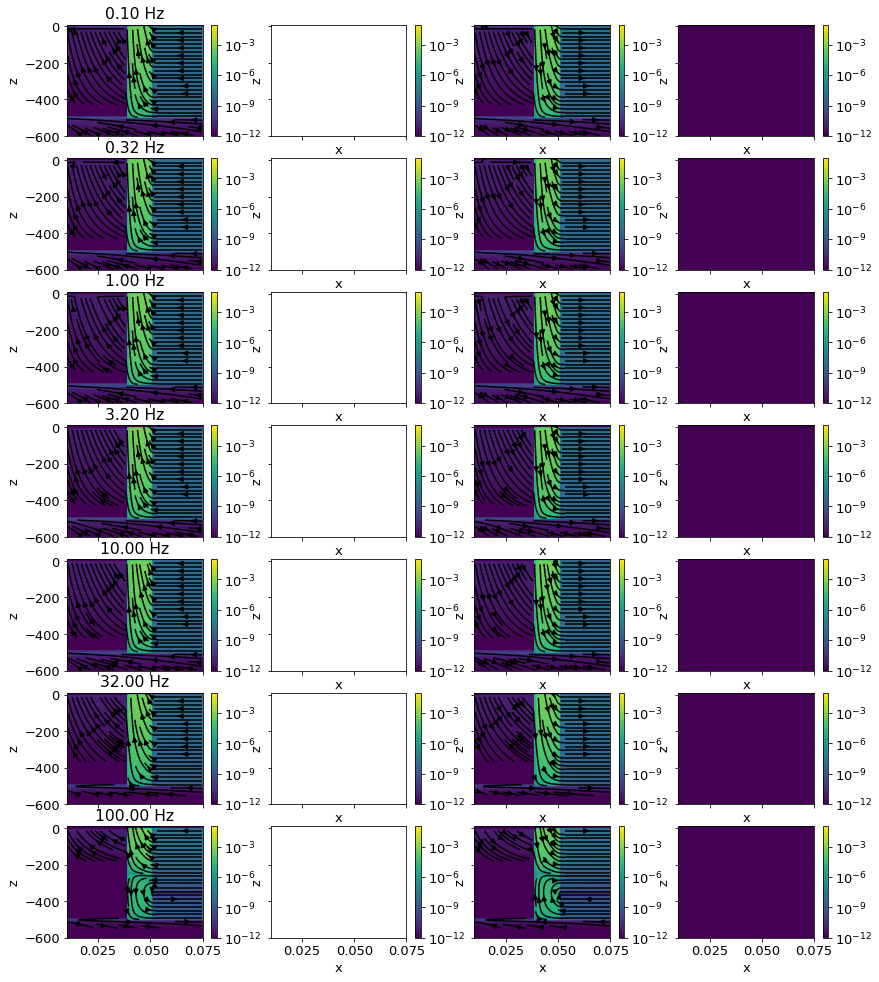

In [1392]:
fig, ax = plt.subplots(
    len(freq_inds_plot), 4, figsize=(14, (len(freq_inds_plot))*2.4),
    sharex=True, sharey=True
)

xlim = np.r_[0.01, 0.075]
zlim = np.r_[-600, 10]
clim = np.r_[1e-12, 1e-1]
reim = "real"
logscale=True

for i, freq_ind in enumerate(freq_inds_plot):
    plot_cell_centered_vector(
        getattr(curl_b[:, freq_ind], reim), 
        theta_ind=3, ax=ax[i, 0], xlim=xlim, zlim=zlim,
        log_scale=logscale, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        getattr(cross_term_2[:, freq_ind], reim), 
        theta_ind=3, ax=ax[i, 1], xlim=xlim, zlim=zlim,
        log_scale=logscale, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        getattr(mu_sigma_e[:, freq_ind], reim), 
        theta_ind=3, ax=ax[i, 2], xlim=xlim, zlim=zlim,
        log_scale=logscale, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        getattr(curl_b[:, freq_ind] + mu_sigma_e[:, freq_ind], reim), 
        theta_ind=3, ax=ax[i, 3], xlim=xlim, zlim=zlim,
        log_scale=logscale, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    
    ax[i, 0].set_title(f"{frequencies[freq_ind]:1.2f} Hz")
    ax[i, 0].set_xlabel("")

In [1393]:
np.abs((curl_mur_h[:, freq_ind] + mur_sigma_e[:, freq_ind]).imag).max()/(cross_term_2_h[:, freq_ind]).imag.max()

/tmp/ipykernel_752/53368212.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs((curl_mur_h[:, freq_ind] + mur_sigma_e[:, freq_ind]).imag).max()/(cross_term_2_h[:, freq_ind]).imag.max()


-inf

In [1394]:
np.abs((curl_mur_h[:, freq_ind] + mur_sigma_e[:, freq_ind]).real).max()/(cross_term_2_h[:, freq_ind]).real.max()



/tmp/ipykernel_752/810538720.py:1: RuntimeWarning: divide by zero encountered in double_scalars
  np.abs((curl_mur_h[:, freq_ind] + mur_sigma_e[:, freq_ind]).real).max()/(cross_term_2_h[:, freq_ind]).real.max()


-inf

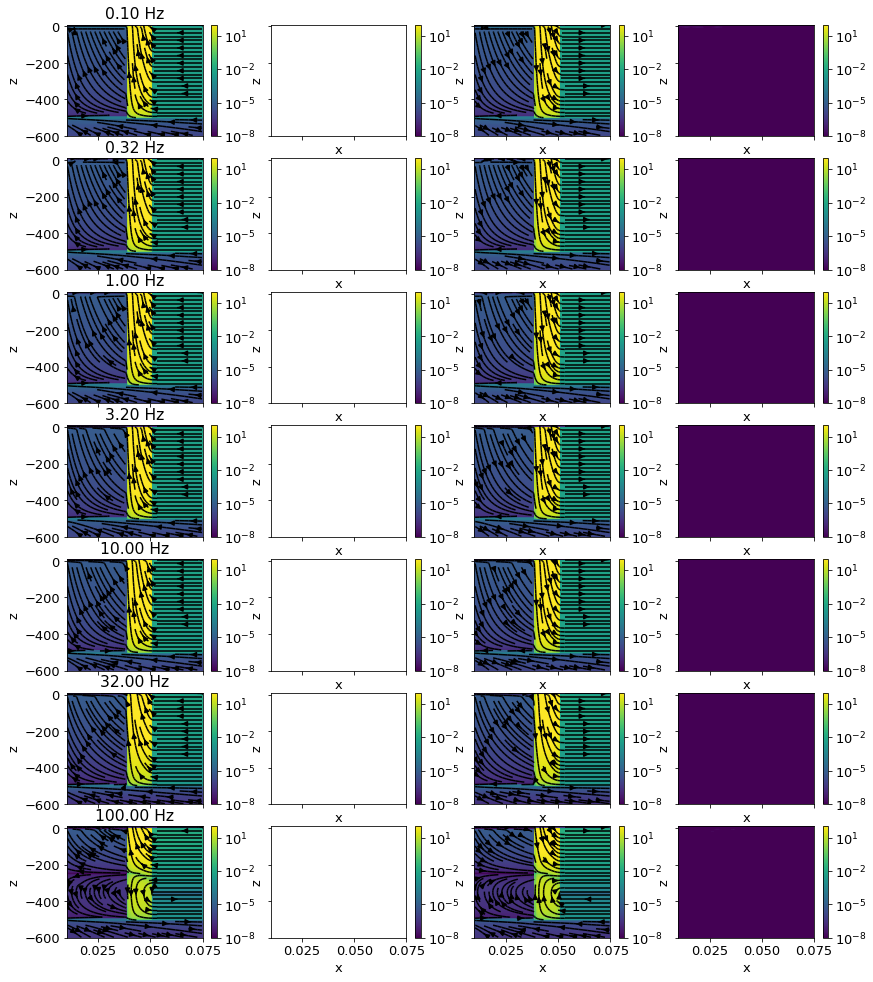

In [1395]:
fig, ax = plt.subplots(
    len(freq_inds_plot), 4, figsize=(14, (len(freq_inds_plot))*2.4),
    sharex=True, sharey=True
)

xlim = np.r_[0.01, 0.075]
zlim = np.r_[-600, 10]
clim = np.r_[1e-8, 1e2]
reim = "real"
logscale=True

for i, freq_ind in enumerate(freq_inds_plot):
    plot_cell_centered_vector(
        getattr(curl_mur_h[:, freq_ind], reim), 
        theta_ind=3, ax=ax[i, 0], xlim=xlim, zlim=zlim,
        log_scale=logscale, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        getattr(cross_term_2_h[:, freq_ind], reim), 
        theta_ind=3, ax=ax[i, 1], xlim=xlim, zlim=zlim,
        log_scale=logscale, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        getattr(mur_sigma_e[:, freq_ind], reim), 
        theta_ind=3, ax=ax[i, 2], xlim=xlim, zlim=zlim,
        log_scale=logscale, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    plot_cell_centered_vector(
        getattr(-(curl_mur_h[:, freq_ind] + mur_sigma_e[:, freq_ind]), reim), 
        theta_ind=3, ax=ax[i, 3], xlim=xlim, zlim=zlim,
        log_scale=logscale, vmin=clim.min(), clim=clim,
        component="xz", show_colorbar=True,
        stream_opts=None
    )
    
    
    ax[i, 0].set_title(f"{frequencies[freq_ind]:1.2f} Hz")
    ax[i, 0].set_xlabel("")

In [1396]:
def plot_cell_centered_vector(
    field_plot, theta_ind=3, ax=None, 
    xlim=600*np.r_[-1, 1], zlim=np.r_[-600, 10],
    real_or_imag="real", 
    log_scale=False, eps=1e-15, vmin=None, clim=None,
    component="both", show_colorbar=True,
    stream_opts=None
):
    if ax is None: 
        fig, ax = plt.subplots(1, 2, figsize=(12,4), sharex=True, sharey=True)

    mesh2d = casing_sim.utils.mesh2d_from_3d(mesh)
    
    components = ["x", "y", "z"]
    field_components = {}

    theta_ind_mirror = casing_sim.view.get_theta_ind_mirror(mesh, theta_ind)

    for i, comp in enumerate(components):
        fieldi = field_plot[i*mesh.n_cells:(i+1)*mesh.n_cells].reshape(
            mesh.vnC, order="F"
        )

        field_components[comp] = {
            "data":discretize.utils.mkvc(fieldi[:, theta_ind]),
            "mirror":(
                discretize.utils.mkvc(fieldi[:, theta_ind_mirror]) * 
                [-1 if comp=="y" else 1][0]
            ),
        }

    if component == "both" or component == "xz": 
        if component == "both":
            ax_xz = ax[0]
        else:
            ax_xz = ax
        # plot x,z vector
        fieldxz = np.hstack([field_components[c]["data"] for c in ["x", "z"]])
        fieldxz_mirror = np.hstack([field_components[c]["mirror"] for c in ["x", "z"]])

        sample_grid=np.r_[np.diff(xlim)/100., np.diff(zlim)/100.]

        vmax = clim.max() if clim is not None else None
        if log_scale is True: 
            norm = LogNorm(vmin=vmin, vmax=vmax)
        else: 
            norm = Normalize(0, vmax)
        out = mesh2d.plot_image(
            fieldxz, v_type="CCv", view="vec", ax=ax_xz,
            range_x=xlim, range_y=zlim,
            sample_grid=sample_grid,
            mirror=True, mirror_data=fieldxz_mirror,
            pcolor_opts={"norm":norm},
            stream_threshold=vmin,
            stream_opts=stream_opts
        )
        if show_colorbar is True: 
            plt.colorbar(out[0], ax=ax_xz)
        
    if component == "both" or component == "y": 
        if component == "both":
            ax_y = ax[1]
        else: 
            ax_y = ax
        
        pcolor_optsy = {"cmap":"Spectral_r"}
        linthresh = vmin if vmin is not None else eps

        if clim is None: 
            # vmin, vmax = np.max(np.abs(
            #     np.hstack([field_components[c]["data"] for c in ["x", "y", "z"]])
            # ))*np.r_[-1, 1]
            vmin, vmax = None, None #norm.vmax*np.r_[-1, 1]
        else: 
            vmin = np.min(clim)
            vmax = np.max(clim)

        if log_scale is True:
            pcolor_optsy["norm"] = SymLogNorm(vmin=vmin, vmax=vmax, linthresh=linthresh)
        else: 
            pcolor_optsy["norm"] = Normalize(vmin=vmin, vmax=vmax)
            
        out2 = mesh2d.plot_image(
            field_components["y"]["data"], ax=ax_y,
            mirror=True, mirror_data=field_components["y"]["mirror"],
            range_x=xlim, range_y=zlim, 
            pcolor_opts=pcolor_optsy
        )
        if show_colorbar is True: 
            plt.colorbar(out2[0], ax=ax_y)
    return ax